In [158]:
#!pip install yfinance
#!pip install mplfinance

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
from pandas.plotting import lag_plot
from mplfinance.original_flavor import candlestick_ohlc
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import os

In [163]:
# CHANGE
# Define the directory for datasets
dataset_dir = r"./datasets"

# Create directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

# Define the date range to be analyzed
START_DATE = '2004-12-01'
END_DATE = '2024-12-31'

# Helper function to convert date formats
def convert_date_format(date, to_monthly=False):
    if to_monthly:
        return pd.to_datetime(date).strftime('%Y-%m')
    return pd.to_datetime(date).strftime('%Y-%m-%d')

# Fetch and save stock data
def fetch_and_save_stock_data(ticker):
    """
    Fetches stock data and saves it with the required column names
    """
    # Download data
    data = yf.download(ticker, start=START_DATE, end=END_DATE)

    # Reset index to get Date as a column
    data = data.reset_index()

    # Rename 'Date' to 'Price' for consistency with existing files
    data = data.rename(columns={'Date': 'Price'})

    # Reorder columns
    data = data[['Price', 'Close', 'High', 'Low', 'Open', 'Volume']]

    # Save in raw format
    filepath = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_data.csv")
    data.to_csv(filepath, index=False)
    return data

# export the cpi data as a pd.DataFrame
def get_cpi_data(start_date, end_date):
    file_path = os.path.join(dataset_dir, 'cpi_inflation_data.xlsx')
    cpi_df = pd.read_excel(file_path)
    
    start_year = pd.to_datetime(start_date).year
    end_year = pd.to_datetime(end_date).year
    
    start_month = pd.to_datetime(start_date).month - 1
    end_month = pd.to_datetime(end_date).month - 1
    
    # Start cleaning the dataframe
    
    cpi_df.drop(columns=["HALF1", "HALF2"], inplace=True)
    
    # Replace the "Month" column with 0-indexed month indices
    melted_inflation = cpi_df.melt(
            id_vars=["Year"],
            value_vars=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
            value_name="CPI"
        )
    month_to_index = {
        "Jan": 0, "Feb": 1, "Mar": 2, "Apr": 3,
        "May": 4, "Jun": 5, "Jul": 6, "Aug": 7,
        "Sep": 8, "Oct": 9, "Nov": 10, "Dec": 11
    }
    melted_inflation["month_idx"] = melted_inflation["variable"].map(month_to_index)
    
    # Calculate Year-over-Year Inflation
    melted_inflation["YoY_Inflation"] = melted_inflation["CPI"].pct_change(periods=1) * 100
    
    # sort the data by year and month
    melted_inflation.sort_values(by=["Year", "month_idx"], inplace=True)
    
    # calculate monthly inflation rate
    melted_inflation["MoM_Inflation"] = melted_inflation["CPI"].pct_change() * 100
    
    # Filter the data based on the date range
    melted_inflation = melted_inflation[
        (melted_inflation["Year"] >= start_year) & (melted_inflation["Year"] <= end_year)
    ]
    melted_inflation = melted_inflation[~((melted_inflation["Year"] == start_year) & (melted_inflation["month_idx"] < start_month))]
    melted_inflation = melted_inflation[~((melted_inflation["Year"] == end_year) & (melted_inflation["month_idx"] > end_month))]
    
    # Create a new date column
    melted_inflation["Month"] = melted_inflation["Year"].astype(str) + "-" + (melted_inflation["month_idx"] + 1).astype(str).str.zfill(2)
    melted_inflation["Date"] = pd.to_datetime(melted_inflation["Month"])
    
    return melted_inflation

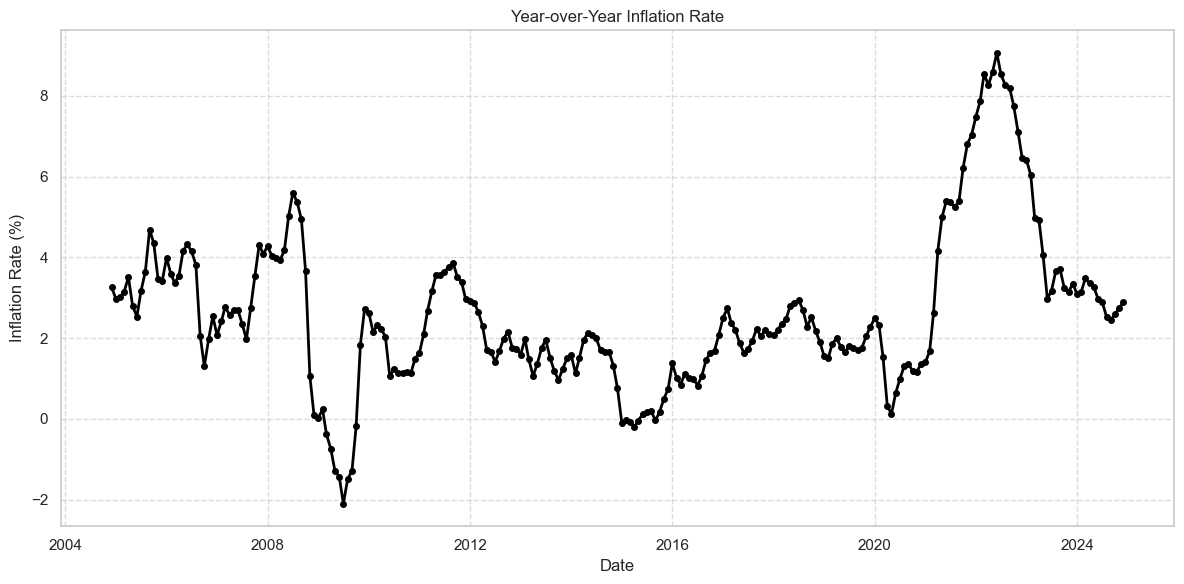

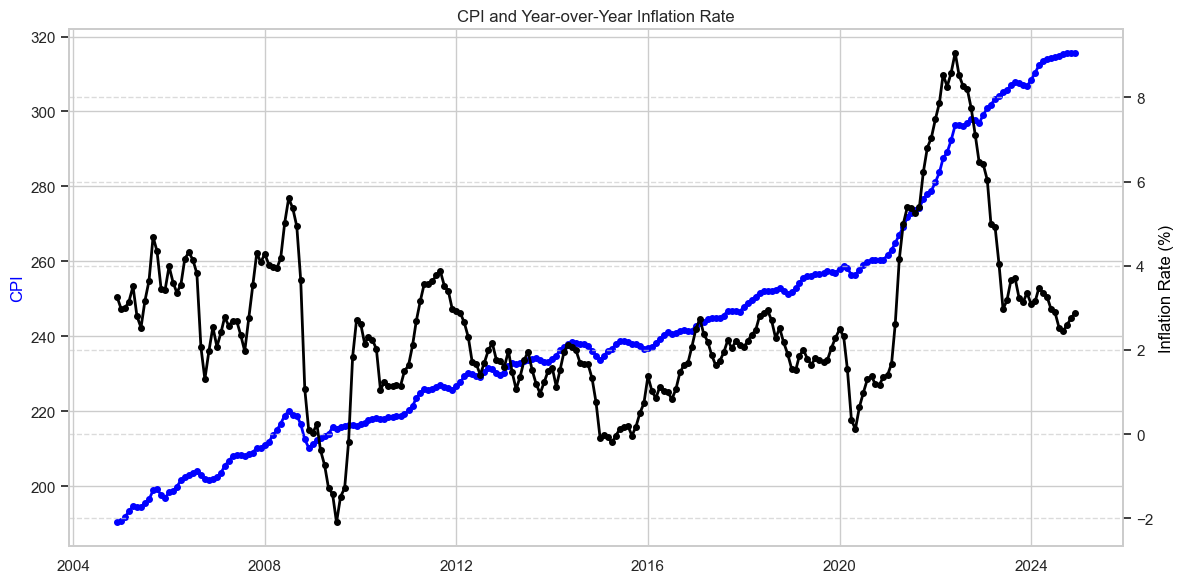

In [164]:
# Fetch, save, clean, and plot inflation rate data
def plot_inflation(start_date, end_date):
    df = get_cpi_data(start_date, end_date)

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['YoY_Inflation'], marker='o', color='black',
             linewidth=2, markersize=4, label='Inflation Rate')
        
    # Format x-axis
    plt.xticks(rotation=0)
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate (%)')
    plt.title('Year-over-Year Inflation Rate')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_inflation_and_cpi(start_date, end_date):
    df = get_cpi_data(start_date, end_date)

    # Create plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    # Plot CPI
    ax1.plot(df['Date'], df['CPI'], marker='o', color='blue',
             linewidth=2, markersize=4, label='CPI')
    ax1.set_ylabel('CPI', color='blue')

    # Plot Inflation Rate
    ax2.plot(df['Date'], df['YoY_Inflation'], marker='o', color='black',
             linewidth=2, markersize=4, label='Inflation Rate')
    ax2.set_ylabel('Inflation Rate (%)', color='black')

    # Format x-axis
    plt.xticks(rotation=0)
    plt.xlabel('Date')
    plt.title('CPI and Year-over-Year Inflation Rate')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_inflation(START_DATE, END_DATE)
plot_inflation_and_cpi(START_DATE, END_DATE)

In [195]:
#Keep Cleaning stock data

def clean_dataset(filepath):
    """
    Cleans a dataset to ensure proper format:
    - Rename Price to Date
    - Remove empty rows and row 2
    - Ensure proper data types
    """
    output_path = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_cleaned.csv")
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Rename 'Price' column to 'Date'
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Date'})
    
    # Remove row 2 and any empty rows
    df = df.dropna(how='all')  # Remove completely empty rows
    if len(df) > 2:  # Make sure we have enough rows
        df = pd.concat([df.iloc[:1], df.iloc[2:]]).reset_index(drop=True)
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # Drop any rows with NaN values after conversion
    df = df.dropna()
    
    # Ensure correct column order
    df = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
    
    df.to_csv(output_path, index=False)

# Define tickers
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', '^GSPC', 'BTC-USD', 'GC=F']

# Step 1: Fetch and save all data
print("Step 1: Fetching and saving raw data...")
raw_data = {}
for ticker in tickers:
    print(f"Fetching data for {ticker}")
    try:
        raw_data[ticker] = fetch_and_save_stock_data(ticker)
        print(f"Successfully saved raw data for {ticker}")
    except Exception as e:
        print(f"Error fetching {ticker}: {str(e)}")

# Step 2: Clean all datasets
print("\nStep 2: Cleaning and saving processed data...")
for ticker in tickers:
    try:
        input_path = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_data.csv")
        print(f"Cleaning data for {ticker}")
        # Verify the output
        print(f"Successfully cleaned and saved data for {ticker}")
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Step 1: Fetching and saving raw data...
Fetching data for META
Successfully saved raw data for META
Fetching data for AAPL
Successfully saved raw data for AAPL
Fetching data for AMZN
Successfully saved raw data for AMZN
Fetching data for NFLX



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully saved raw data for NFLX
Fetching data for GOOG
Successfully saved raw data for GOOG
Fetching data for ^GSPC
Successfully saved raw data for ^GSPC
Fetching data for BTC-USD
Successfully saved raw data for BTC-USD
Fetching data for GC=F
Successfully saved raw data for GC=F

Step 2: Cleaning and saving processed data...
Cleaning data for META
Successfully cleaned and saved data for META
Cleaning data for AAPL
Successfully cleaned and saved data for AAPL
Cleaning data for AMZN
Successfully cleaned and saved data for AMZN
Cleaning data for NFLX
Successfully cleaned and saved data for NFLX
Cleaning data for GOOG
Successfully cleaned and saved data for GOOG
Cleaning data for ^GSPC
Successfully cleaned and saved data for ^GSPC
Cleaning data for BTC-USD
Successfully cleaned and saved data for BTC-USD
Cleaning data for GC=F
Successfully cleaned and saved data for GC=F


In [196]:
# Define file names and colors for all datasets
stock_names_color = {
    "Amazon": "#FF9900",    # Amazon orange
    "Apple": "#A2AAAD",     # Apple silver
    "Bitcoin": "#00FF00", # Bitcoin green
    "Facebook": "#0668E1",   # Meta blue
    "Google": "#4285F4",     # Google blue
    "Netflix": "#E50914",    # Netflix red
    "S&P 500": "#0033A0",    # Dark blue
    "Gold": "#FFD700"        # Gold
}

In [197]:
# Function to load cleaned data
def load_cleaned_data(ticker):
    """Load cleaned data from CSV and set Date as index"""
    file_path = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_cleaned.csv")
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # add a column for the average monthly price
    df['Month'] = df.index.year.astype(str) + '-' + df.index.month.astype(str).str.zfill(2)
    df['Monthly_Avg'] = df.groupby('Month')['Close'].transform('mean')
    return df

# Load all cleaned data
meta = load_cleaned_data('META')
aapl = load_cleaned_data('AAPL')
amzn = load_cleaned_data('AMZN')
nflx = load_cleaned_data('NFLX')
goog = load_cleaned_data('GOOG')
sp500 = load_cleaned_data('GSPC')
bitcoin = load_cleaned_data('BTC-USD')
gold = load_cleaned_data('GC=F')

# Create FAANG portfolio
FAANG = {
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
}

# Create FAANG + Gold portfolio
FAANG_GOLD = {
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold
}

# Create All Assets dict
ALL_ASSETS = {
    'Amazon': amzn,
    'Apple': aapl,
    'Bitcoin': bitcoin,
    'Facebook': meta,
    'Gold': gold,
    'Google': goog,
    'Netflix': nflx,
    'S&P 500': sp500,
}

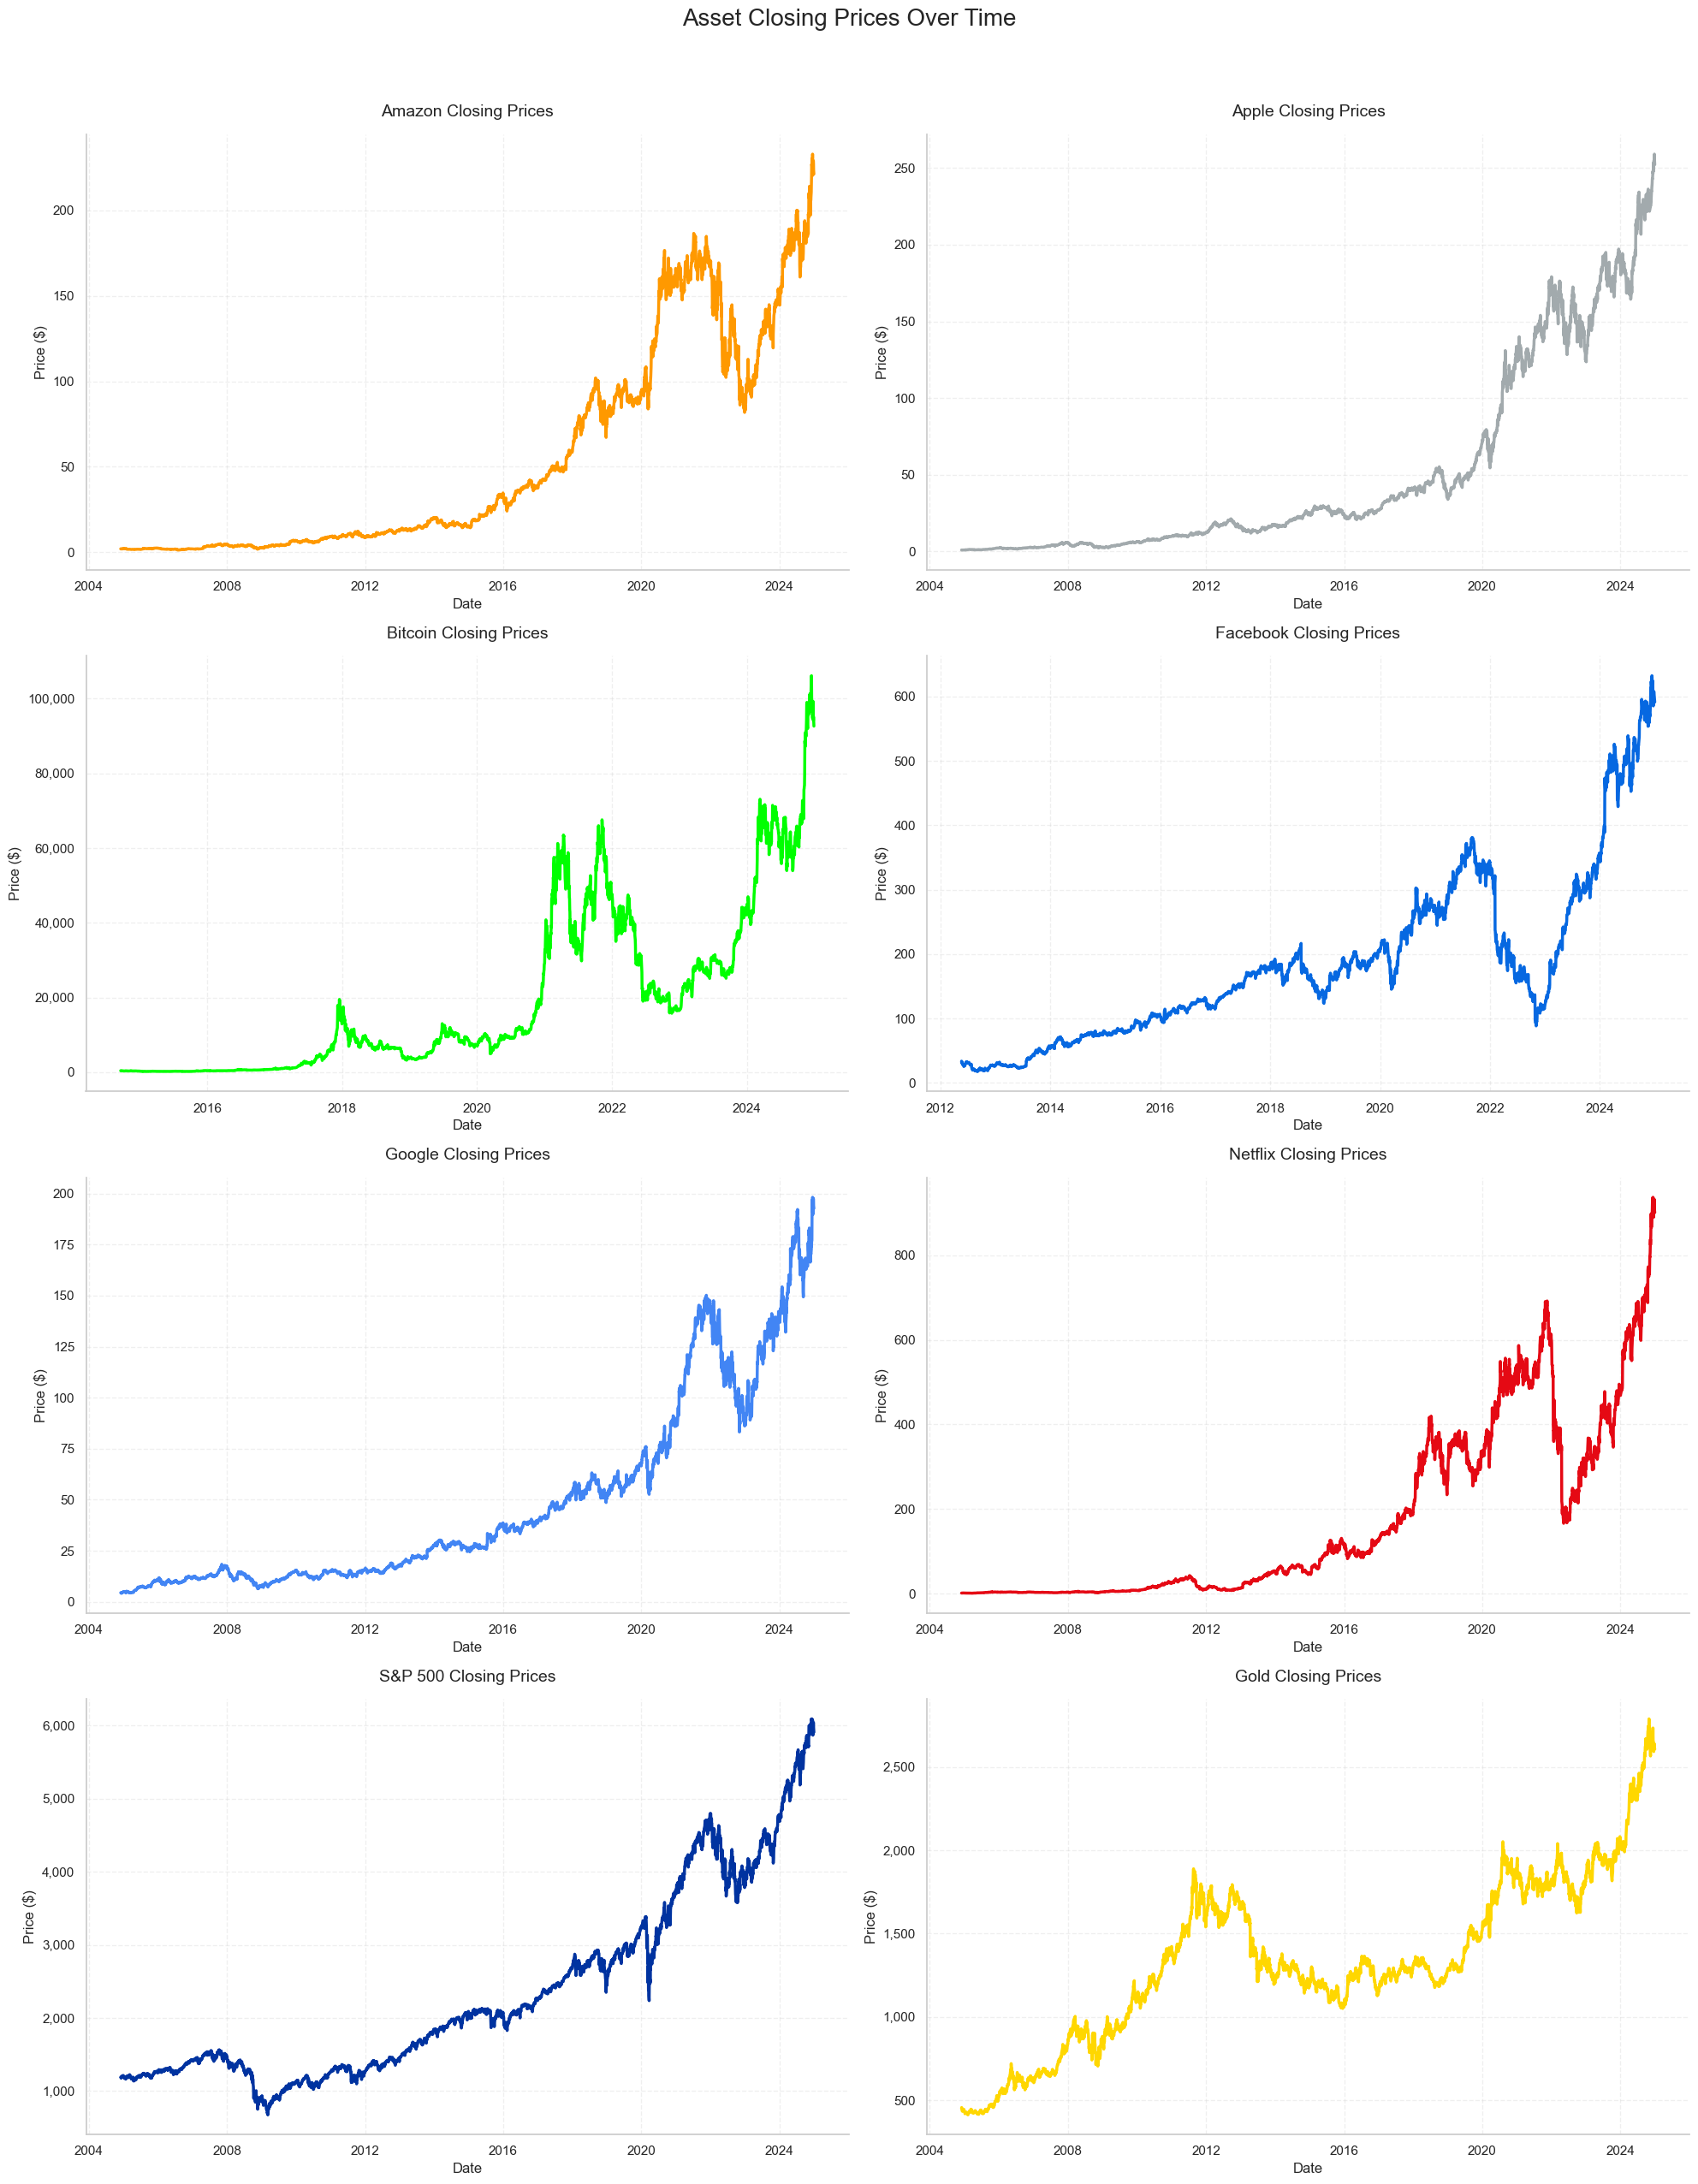

In [198]:
# Create subplots for each dataset
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Asset Closing Prices Over Time', fontsize=20, y=1.02)

# Flatten axs for easier iteration
axs_flat = axs.flatten() # transforms a 2D array of subplot objects into a 1D array

# Plot each dataset 
for idx, (stock, color) in enumerate(stock_names_color.items()):
    # Read data
    df = ALL_ASSETS[stock]
    
    # Create plot with seaborn
    sns.lineplot(data=df, x='Date', y='Close', color=color, ax=axs_flat[idx], 
                linewidth=2.5)
    
    # Customize plot 
    axs_flat[idx].set_title(f'{stock} Closing Prices', fontsize=14, pad=15)
    axs_flat[idx].set_xlabel('Date', fontsize=12)
    axs_flat[idx].set_ylabel('Price ($)', fontsize=12)
    axs_flat[idx].tick_params(axis='x', rotation=0)
    axs_flat[idx].grid(True, alpha=0.3, linestyle='--')
    
    # Format y-axis with comma separator and proper decimal handling
    axs_flat[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    
    # Set spines
    axs_flat[idx].spines['top'].set_visible(False)
    axs_flat[idx].spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

plt.show()


# Assets summary statistics and insights

In [199]:
all_assets_stats = {}

for stock_name, stock_df in ALL_ASSETS.items():
    stats = stock_df['Close'].describe()
    stats = stats.round(2)
    if stats is not None:
        all_assets_stats[stock_name] = stats

# Create a DataFrame to consolidate the statistics
if all_assets_stats:
    summary_df = pd.DataFrame(all_assets_stats)

    # Create the final summary DataFrame with proper column names
    final_summary = pd.DataFrame({
        'Count': summary_df.loc['count'],
        'Mean': summary_df.loc['mean'],
        'Std Dev': summary_df.loc['std'],
        'Minimum': summary_df.loc['min'],
        '25th Percentile': summary_df.loc['25%'],
        'Median': summary_df.loc['50%'],
        '75th Percentile': summary_df.loc['75%'],
        'Maximum': summary_df.loc['max']
    })

    # Display results
    print("\nSummary Statistics for All Assets:")
    print("=" * 80)
    print(final_summary.T)

    # Print key insights
    print("\nKey Insights:")
    print("-" * 80)
    print(f"Highest average price: {final_summary['Mean'].idxmax()} (${final_summary['Mean'].max():,.2f})")
    print(f"Lowest average price: {final_summary['Mean'].idxmin()} (${final_summary['Mean'].min():,.2f})")
    print(f"Most volatile asset (highest std dev): {final_summary['Std Dev'].idxmax()}")
    print(f"Most stable asset (lowest std dev): {final_summary['Std Dev'].idxmin()}")

    # Additional insights
    print("\nVolatility Analysis:")
    print("-" * 80)
    for asset in final_summary.index:
        mean = final_summary.loc[asset, 'Mean']
        std = final_summary.loc[asset, 'Std Dev']
        cv = std / mean  # Coefficient of Variation
        print(f"{asset}: CV = {cv:.4f} (Std Dev / Mean)")
else:
    print("No data processed.")



Summary Statistics for All Assets:
                  Amazon    Apple    Bitcoin  Facebook     Gold   Google  \
Count            5053.00  5053.00    3757.00   3173.00  5045.00  5053.00   
Mean               54.07    51.24   19571.29    184.89  1335.04    48.35   
Std Dev            60.60    63.24   22097.39    129.73   481.64    46.41   
Minimum             1.30     0.94     178.10     17.66   412.60     4.22   
25th Percentile     5.92     5.99    1229.08     87.68  1076.40    13.25   
Median             18.67    22.22    9350.53    165.21  1292.90    27.87   
75th Percentile    94.33    64.10   30548.70    241.57  1710.50    63.93   
Maximum           232.93   259.02  106140.60    632.17  2788.50   198.16   

                 Netflix  S&P 500  
Count            5053.00  5053.00  
Mean              175.54  2348.57  
Std Dev           208.52  1275.32  
Minimum             1.29   676.53  
25th Percentile     7.79  1309.93  
Median             64.05  1979.92  
75th Percentile   330.13  2

# Histogram of Assets clossing prices distribution

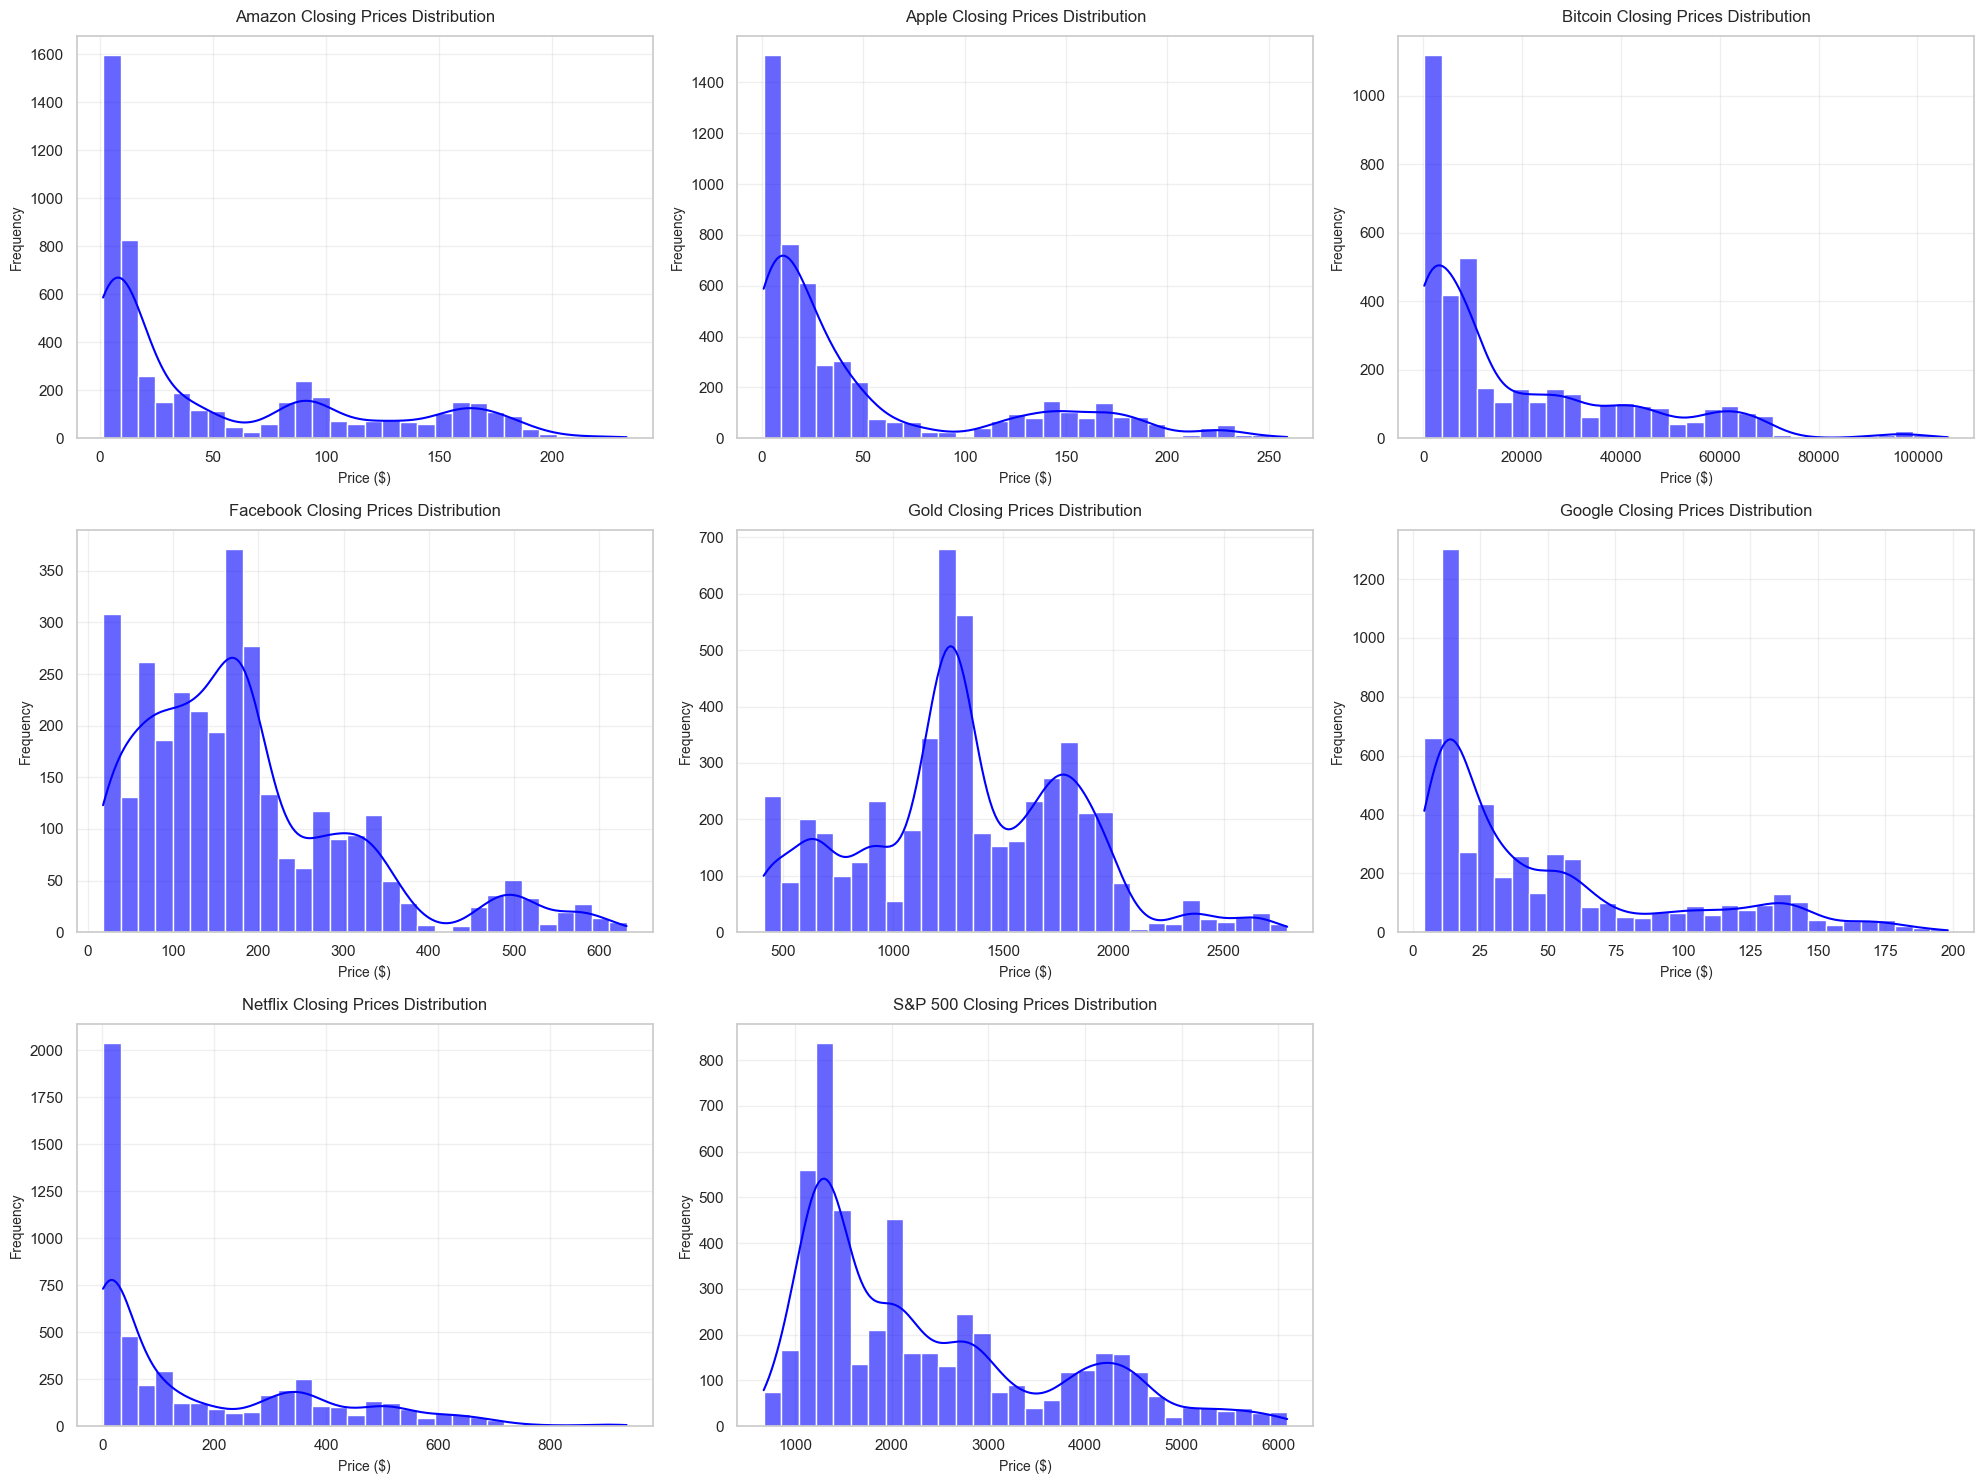

In [200]:
# Load all closing prices into a dictionary
closing_prices = {}
for stock_name, stock_df in ALL_ASSETS.items():
    closing_prices[stock_name] = stock_df['Close']

# Create histograms
plt.figure(figsize=(20, 15))

# Calculate number of rows and columns needed
n_stocks = len(closing_prices)
n_cols = 3
n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

# Create subplots for each stock
for i, (stock, prices) in enumerate(closing_prices.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Create histogram with KDE
    sns.histplot(data=prices.dropna(), 
                bins=30, 
                kde=True,
                color='blue',
                alpha=0.6)
    
    # Customize the subplot
    plt.title(f'{stock} Closing Prices Distribution', fontsize=12, pad=10)
    plt.xlabel('Price ($)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Heatmap of Correlation Matrix and Pairplot for all assets

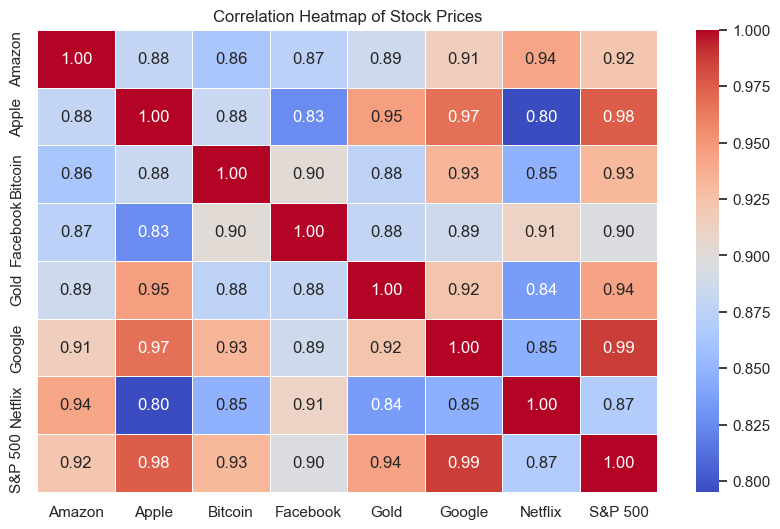

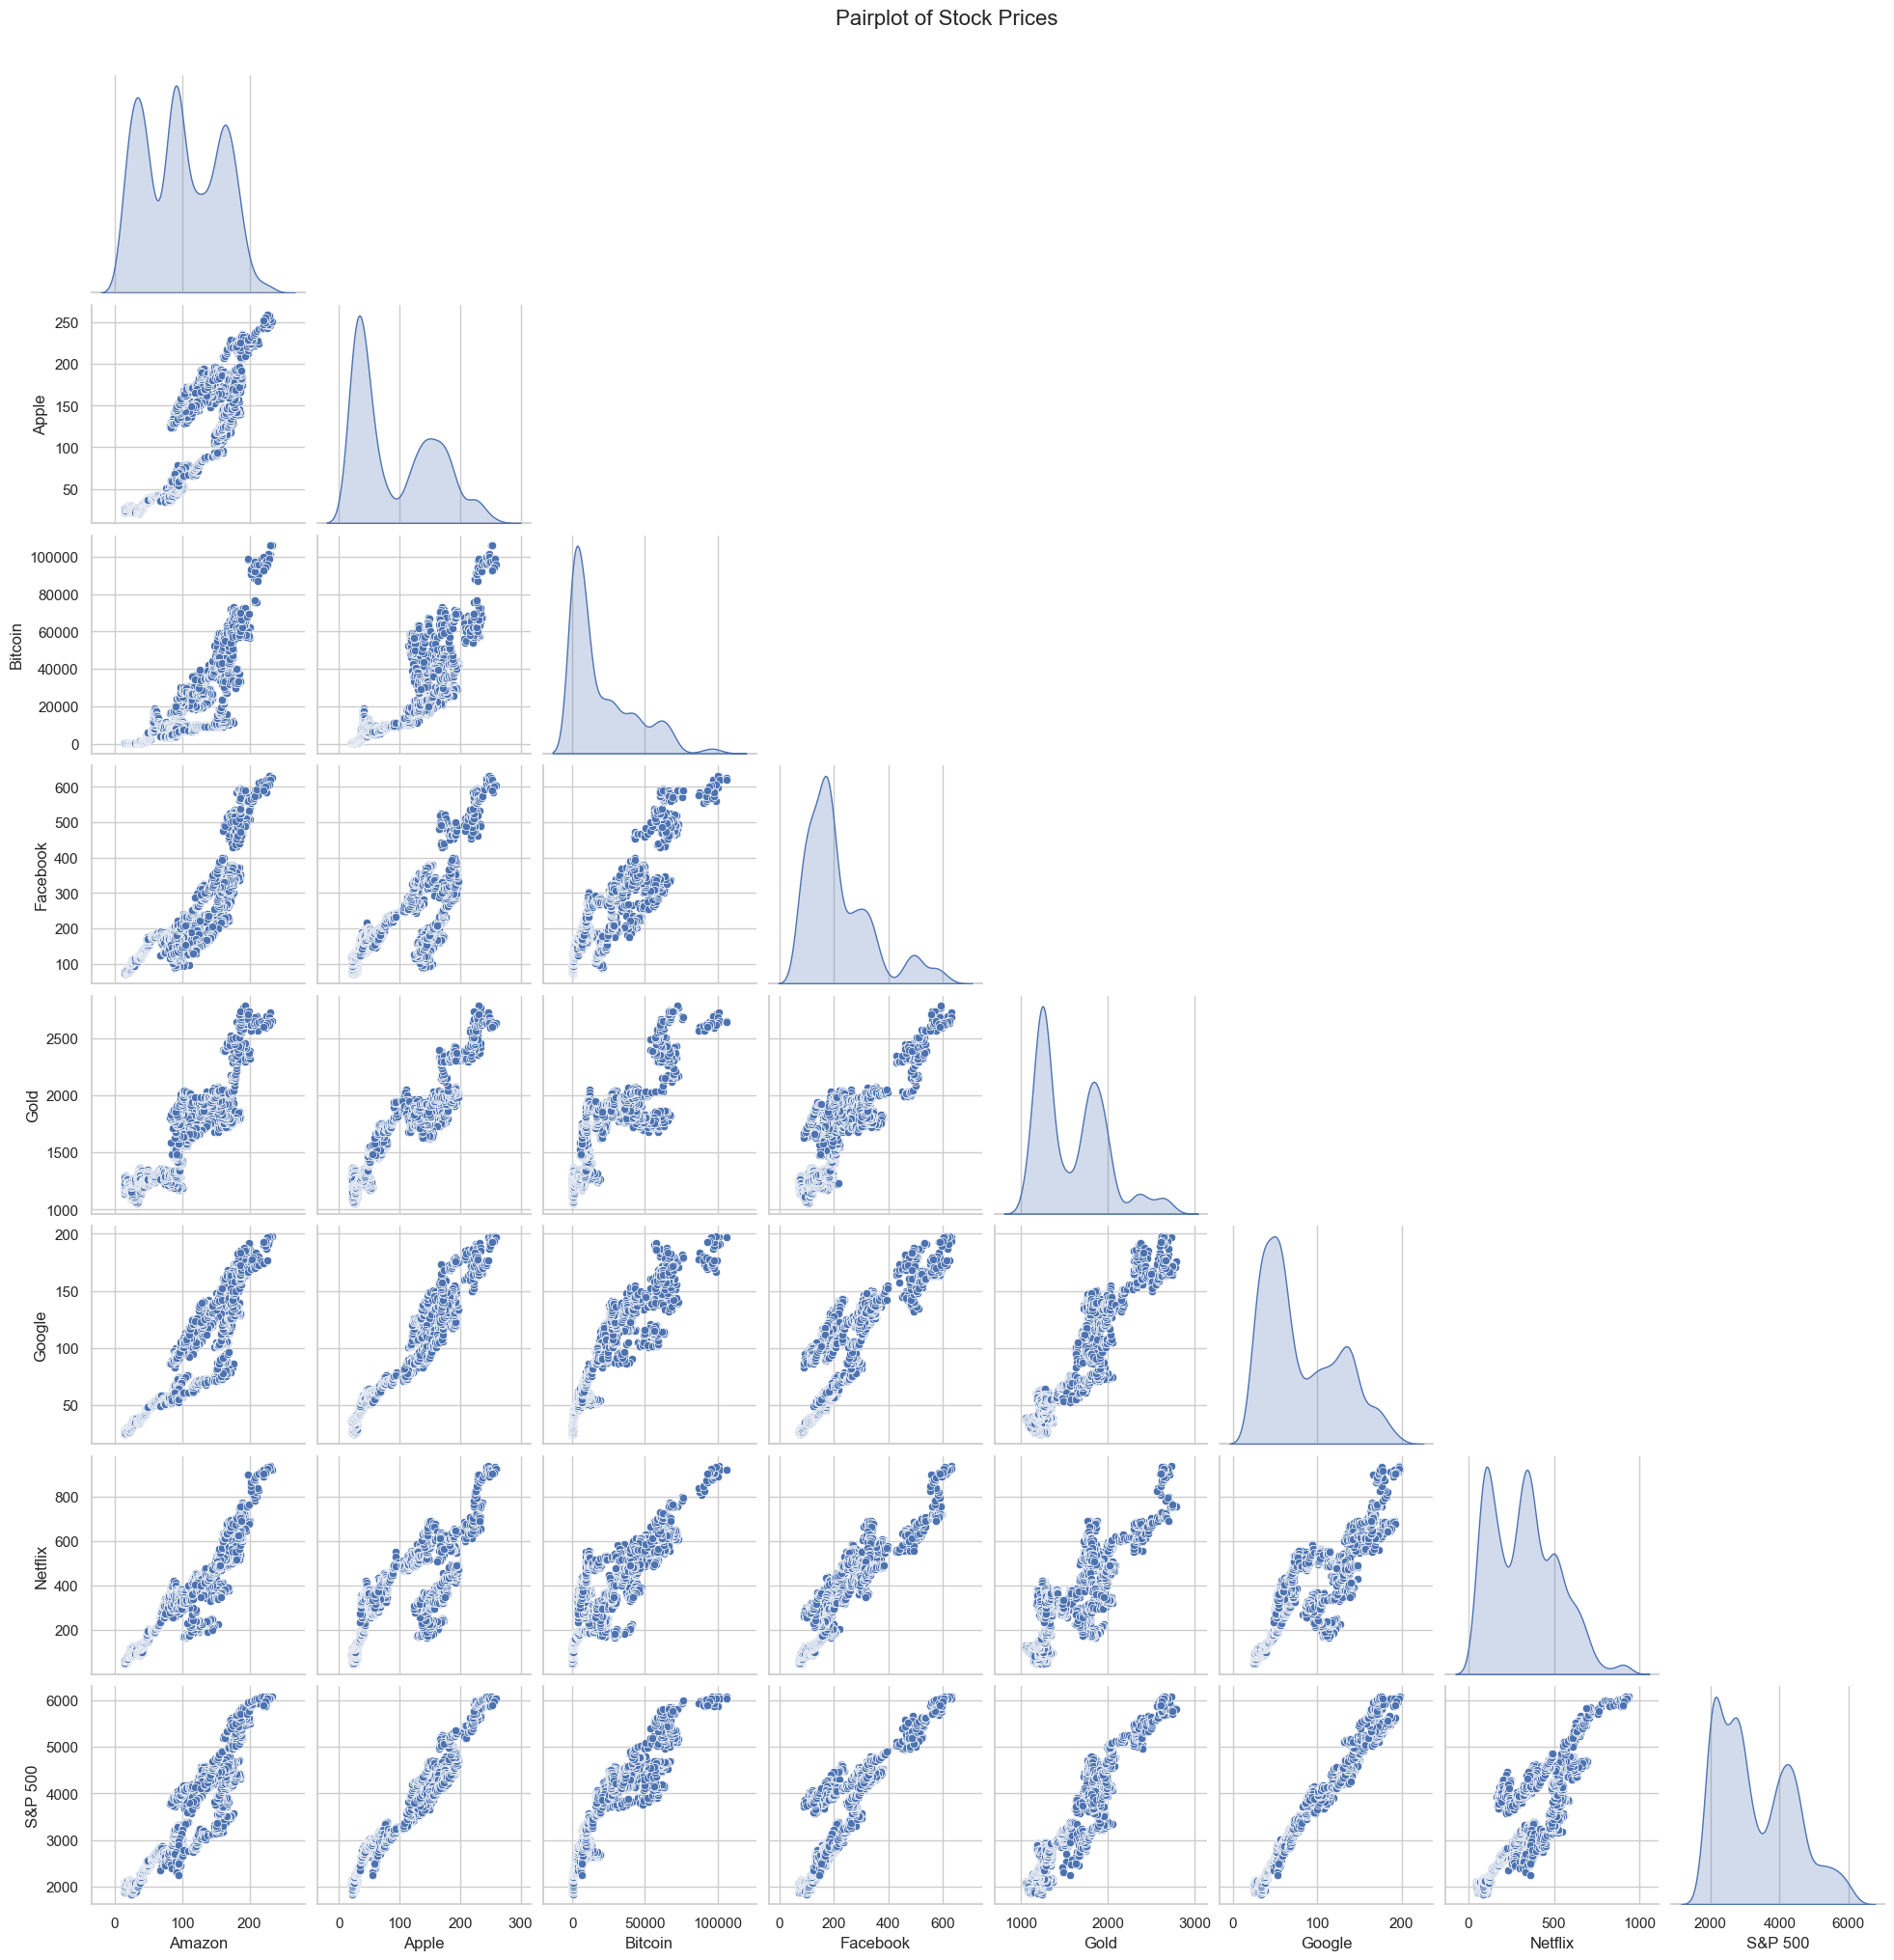

In [201]:
# Combine the 'Close' prices of all assets into a single DataFrame
close_prices_combined = pd.DataFrame(closing_prices)

# Drop rows with missing data
close_prices_combined.dropna(inplace=True)

# Compute the correlation matrix
correlation_matrix = close_prices_combined.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Stock Prices")
plt.show()

# Create pairplot for stock prices only
sns.pairplot(close_prices_combined, diag_kind="kde", kind="scatter", corner=True)
plt.suptitle("Pairplot of Stock Prices", y=1.02, fontsize=16)
plt.show()

# Heatmap and pairplot with assets monthly averages and inflation rate
## Why Are Monthly Averages Better?
### Mitigates Daily Volatility:
 - Stock prices can exhibit significant daily fluctuations due to short-term factors like market sentiment, news, or events.
 - Using a single day's closing price (e.g., the last trading day) might misrepresent the true trend of the stock for 
that month, especially if that day was an outlier.
 - Monthly averages smooth out these fluctuations and provide a more reliable representation of the stock's performance.
 - Better Alignment with Inflation Trends:
 - Inflation is a macroeconomic indicator that reflects broader trends rather than daily changes. It has a cumulative effect over the entire month.
 - Monthly averages ensure the stock data corresponds to this time frame, improving the relevance of the correlation analysis.
### Reduces Noise:
 - Outliers in daily prices, such as sudden spikes or dips, can distort correlations when using a single day's closing price.
 - Averages reduce the impact of outliers and provide a more stable basis for comparison.
### Consistency Across Assets:
 - Different assets (e.g., stocks, Bitcoin, gold) trade on different schedules. Some might not trade daily or on weekends.
 - Using monthly averages ensures consistency in the time period analyzed for all assets.
### Improves Statistical Robustness:
 - Averages are less sensitive to random fluctuations and ensure that the correlation results are more reliable and reflective of general trends.

## Advantages in the Heatmap
### Improved Reliability:
 - The heatmap now reflects correlations based on a more stable dataset (monthly averages), reducing the likelihood of misleading results caused by day-to-day noise.
### Better Interpretability:
 - Correlations are easier to interpret as they represent relationships between inflation and more generalized stock performance over the month, rather than just a single day's snapshot.
## Drawbacks of Using Monthly Averages
### Loss of Granularity:
 - Averaging eliminates daily price trends and may overlook short-term relationships or events.
 - If analyzing short-term impacts of inflation or specific events, daily data might be more appropriate.
### Potential Lag Effects:
 - Inflation's impact on stock prices might not appear in the same month. Lagging inflation data by one or more months could improve correlations.
## Conclusion
Using monthly averages balances the trade-off between granularity and reliability, making it ideal for long-term and trend-based 
analyses like inflation's relationship with stock prices. This method ensures more stable and interpretable results, especially for macroeconomic studies.

In [202]:
# get the real price of the asset by dividing the closing price by the CPI
def get_real_price(asset_df):
    start_date = asset_df.index.min()
    end_date = asset_df.index.max()
    
    inflation_df = get_cpi_data(start_date, end_date)
    new_df = asset_df.copy()
    # merge the two dataframes on the date
    merged_df = pd.merge(new_df, inflation_df, on='Month')
    
    curr_inflation = inflation_df["CPI"].values[-1]
    
    # calculate the real price
    merged_df['Real_Close'] = merged_df['Close'] / (merged_df["CPI"] / curr_inflation)
    
    columns_to_drop = ["Close", "Year", "variable", "CPI", "month_idx", "MoM_Inflation", "YoY_Inflation", "Month"]
    merged_df.drop(columns=columns_to_drop, inplace=True)
    
    return merged_df
    

ALL_ASSETS_REAL = {}
for stock_name, stock_df in ALL_ASSETS.items():
    ALL_ASSETS_REAL[stock_name] = get_real_price(stock_df)
    

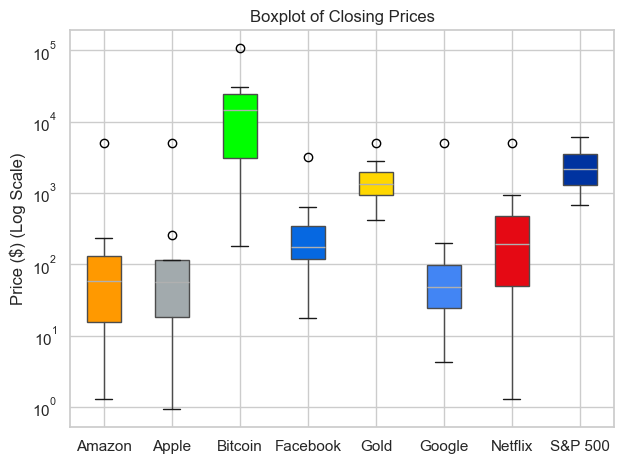

In [203]:
# Assets Boxplot

# Convert the dictionary to a DataFrame
all_assets_df = pd.DataFrame(all_assets_stats)

# Generate a boxplot
boxplot = all_assets_df.boxplot(patch_artist=True, return_type='dict')

# Apply colors to the boxes
colors = [stock_names_color[asset] for asset in all_assets_df.columns]  # Extract colors in column order
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Customize the plot
plt.yscale('log')  # If you prefer a logarithmic scale
plt.title('Boxplot of Closing Prices')
plt.ylabel('Price ($) (Log Scale)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

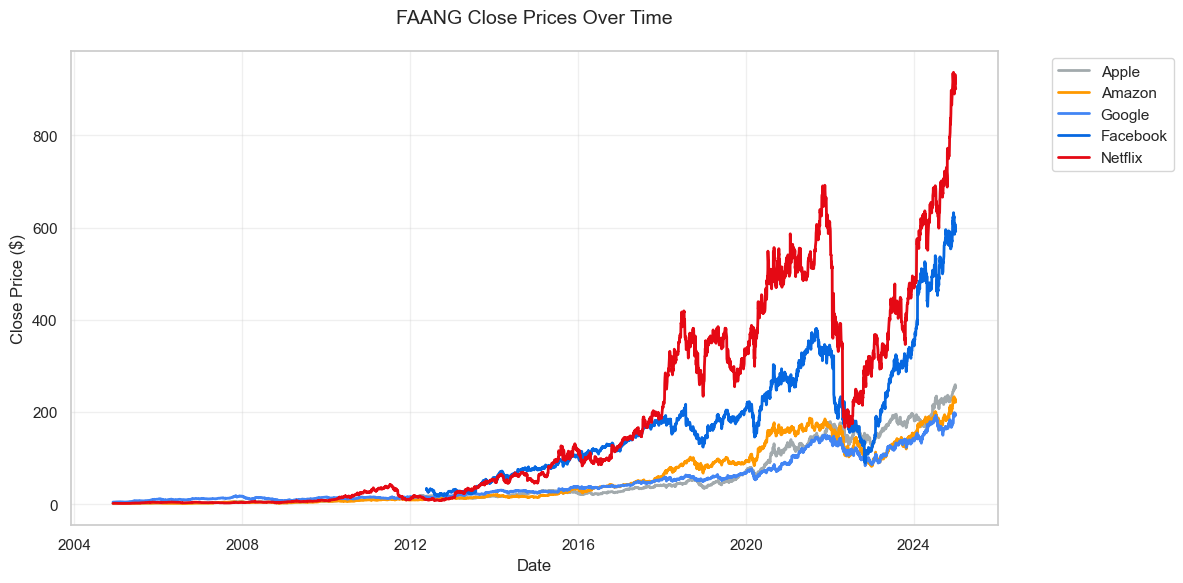

In [217]:
#Line plot for FAANG stock prices (Close)

# TODO normalize the prices
# Name mapping for clearer labels
names =  ['Apple', 'Amazon', 'Google', 'Facebook', 'Netflix']

# Line plot for FAANG stock prices (Close)
plt.figure(figsize=(12, 6))

for company in names:
    plt.plot(ALL_ASSETS[company].index, 
            ALL_ASSETS[company]['Close'], 
            label=company,
            color=stock_names_color[company],
            linewidth=2)

plt.title('FAANG Close Prices Over Time', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

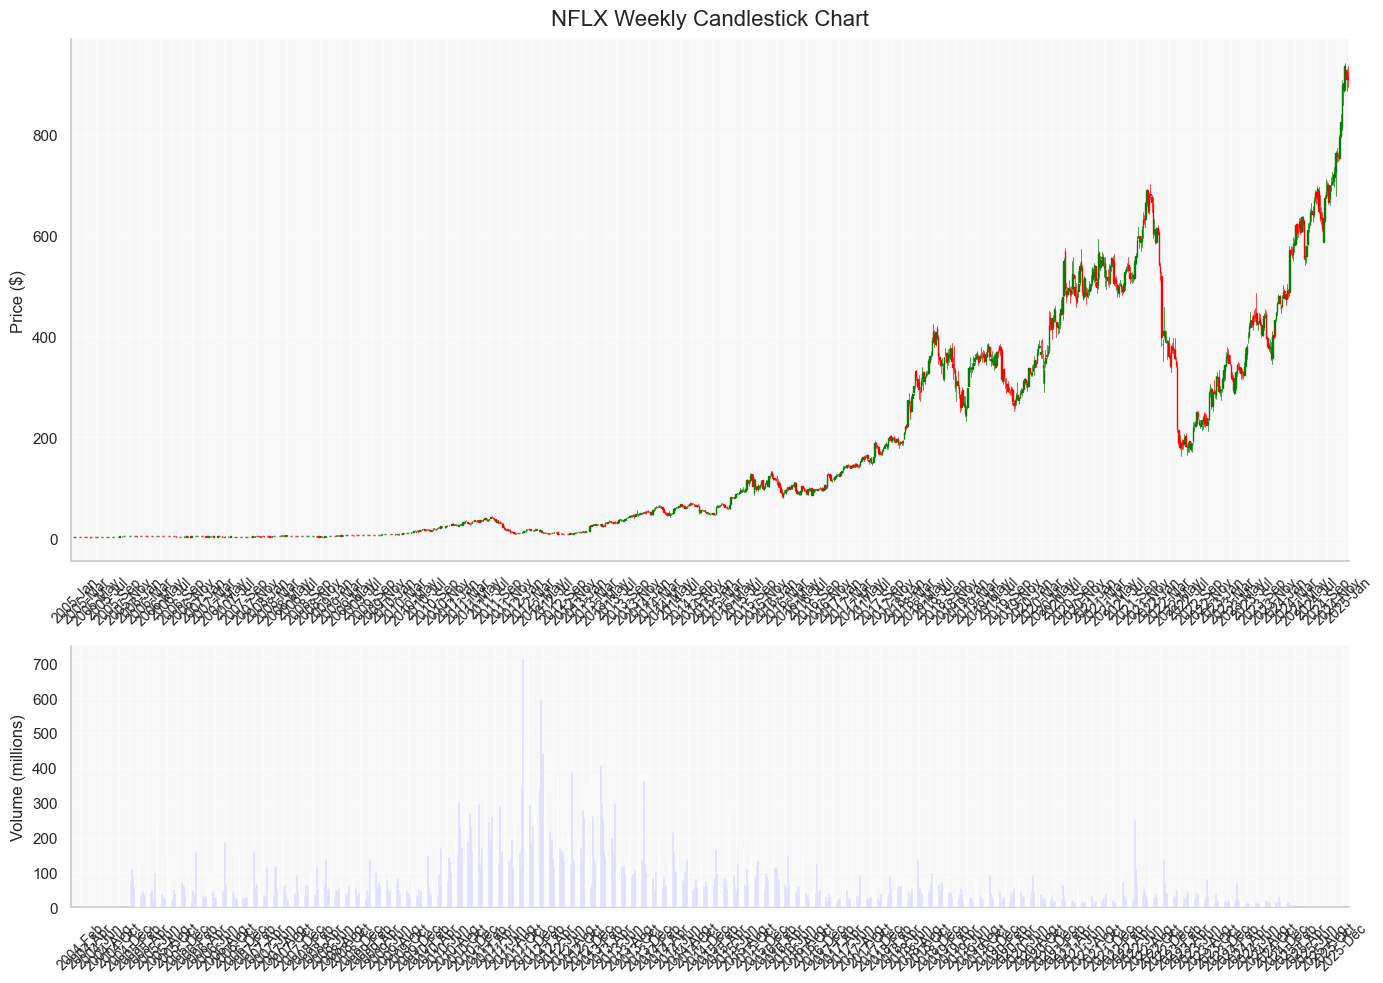


Weekly Trading Summary:
Number of weeks: 1049
Average weekly volume: 73.10M
Highest weekly close: $934.74
Lowest weekly close: $1.29


In [219]:
# Candlesticks plot for Netflix stock

# Read the data
df = nflx.copy()

df['Date'] = df.index

# Resample to weekly data
weekly = df.set_index('Date').resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                              gridspec_kw={'height_ratios': [2, 1]},
                              facecolor='white')
plt.subplots_adjust(hspace=0.2)

# Prepare OHLC data
ohlc = weekly[['Date', 'Open', 'High', 'Low', 'Close']].copy()
ohlc['Date'] = ohlc['Date'].map(mdates.date2num)

# Plot candlestick chart
candlestick_ohlc(ax1, ohlc.values, width=3, 
                 colorup='green', colordown='red',
                 alpha=1)

# Configure the price axis
ax1.set_title('NFLX Weekly Candlestick Chart', fontsize=16, pad=10)
ax1.set_facecolor('#F7F7F7')
ax1.grid(True, color='white', linewidth=0.7, alpha=0.6, zorder=0)
ax1.set_ylabel('Price ($)', fontsize=12)

# Dynamically adjust the x-axis for the price chart
ax1.set_xlim(ohlc['Date'].min(), ohlc['Date'].max())
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Adjust interval to every 2 months
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Add minor ticks for each month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Plot weekly volume bars
ax2.bar(weekly['Date'], weekly['Volume']/1e6, 
        width=3, color='blue', alpha=0.7, zorder=3)
ax2.set_facecolor('#F7F7F7')
ax2.grid(True, color='white', linewidth=0.7, alpha=0.6, zorder=0)
ax2.set_ylabel('Volume (millions)', fontsize=12)

# Format x-axis for the volume chart
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Match with price chart
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax2.tick_params(axis='x', rotation=45, labelsize=10)

# Remove top and right spines for both charts
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout for better readability
plt.tight_layout()

plt.show()

# Print some statistics
print("\nWeekly Trading Summary:")
print("=" * 50)
print(f"Number of weeks: {len(weekly)}")
print(f"Average weekly volume: {weekly['Volume'].mean()/1e6:.2f}M")
print(f"Highest weekly close: ${weekly['Close'].max():.2f}")
print(f"Lowest weekly close: ${weekly['Close'].min():.2f}")

# Risk and Return Analysis


Comprehensive Asset Analysis:
          Annualized Volatility  Sharpe Ratio  Maximum Drawdown    Beta  \
Asset                                                                     
Amazon                   0.3794        0.6744           -0.6525  1.1417   
Apple                    0.3215        0.8665           -0.6087  1.0735   
Bitcoin                  0.5746        0.8318           -0.8340  0.6657   
Facebook                 0.3974        0.6444           -0.7674  0.9572   
Google                   0.3004        0.6087           -0.6529  1.0221   
Netflix                  0.5043        0.7793           -0.8199  1.0051   
S&P 500                  0.1914        0.2523           -0.5678  1.0000   
Gold                     0.1767        0.3019           -0.4436  0.0270   

          Mean Daily Return  Median Daily Return  Start Price   End Price  \
Asset                                                                       
Amazon               0.0012               0.0007       2.0085   

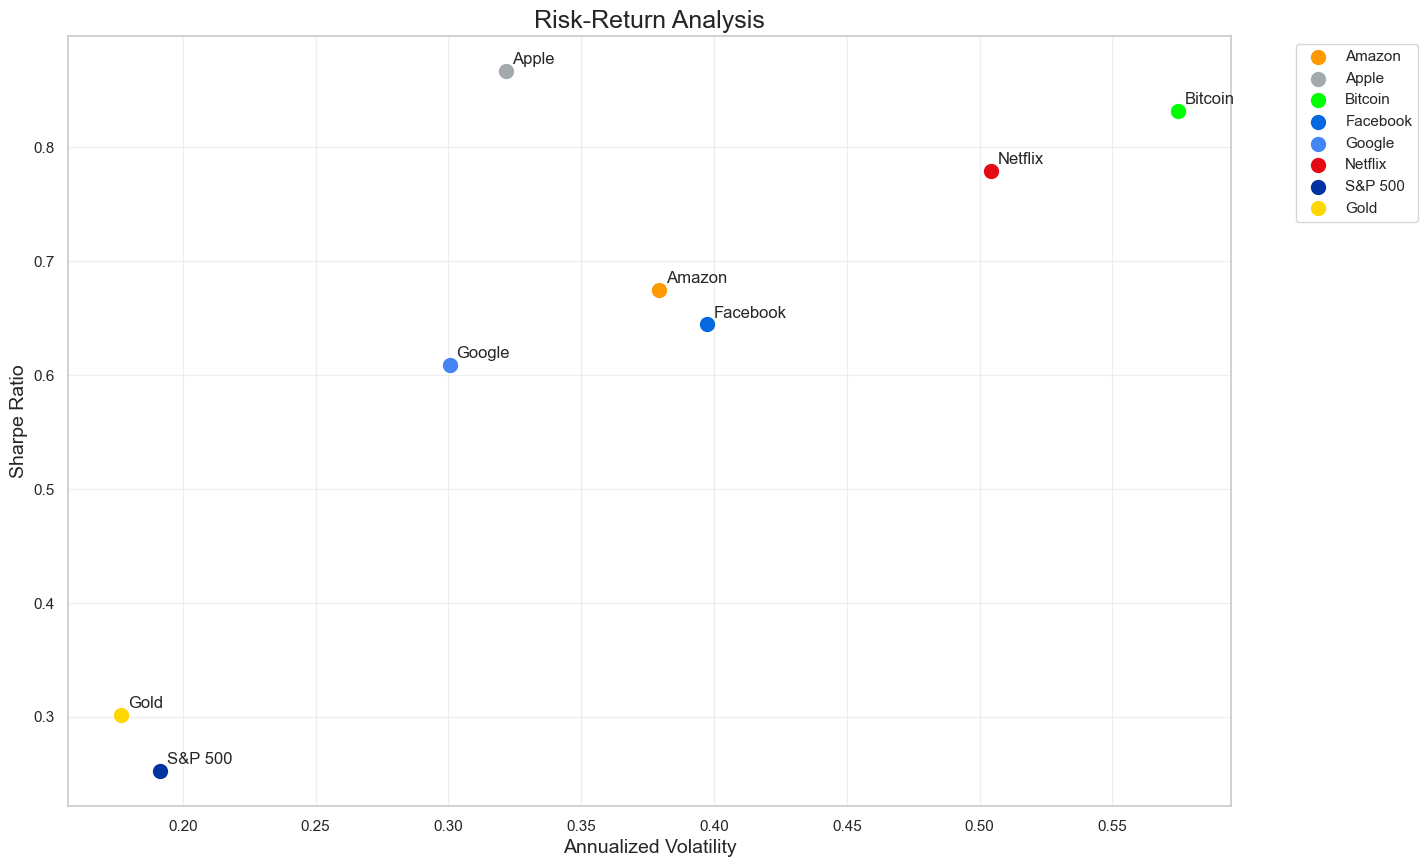


Key Findings:
--------------------------------------------------------------------------------
Highest Sharpe Ratio: Apple (0.8665)
Lowest Volatility: Gold (0.1767)
Highest Total Return: Netflix (55433.11%)
Most Defensive (Lowest Beta): Gold (0.0270)

Risk-Return Profile:
--------------------------------------------------------------------------------
Amazon:
  - Risk (Volatility): 37.94%
  - Risk-Adjusted Return (Sharpe): 0.6744
  - Market Sensitivity (Beta): 1.1417
  - Total Return: 10918.17%

Apple:
  - Risk (Volatility): 32.15%
  - Risk-Adjusted Return (Sharpe): 0.8665
  - Market Sensitivity (Beta): 1.0735
  - Total Return: 25574.95%

Bitcoin:
  - Risk (Volatility): 57.46%
  - Risk-Adjusted Return (Sharpe): 0.8318
  - Market Sensitivity (Beta): 0.6657
  - Total Return: 21727.16%

Facebook:
  - Risk (Volatility): 39.74%
  - Risk-Adjusted Return (Sharpe): 0.6444
  - Market Sensitivity (Beta): 0.9572
  - Total Return: 1644.04%

Google:
  - Risk (Volatility): 30.04%
  - Risk-Adjusted 

In [223]:
class StockAnalyzer:
    def __init__(self, data, name):
        self.data = data
        self.name = name
    
    def annualized_volatility(self):
        """Calculate annualized volatility"""
        daily_returns = self.data['Close'].pct_change()
        return daily_returns.std() * np.sqrt(252)
    
    def daily_returns(self):
        """Calculate daily returns"""
        return self.data['Close'].pct_change()
    
    def sharpe_ratio(self, risk_free_rate=0.05):
        """Calculate Sharpe ratio with given risk-free rate"""
        daily_returns = self.daily_returns()
        excess_returns = daily_returns - risk_free_rate/252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    def max_drawdown(self):
        """Calculate maximum drawdown"""
        cumulative = (1 + self.daily_returns()).cumprod()
        rolling_max = cumulative.expanding(min_periods=1).max()
        drawdowns = cumulative/rolling_max - 1
        return drawdowns.min()
    
    def beta(self, market_data):
        """Calculate beta relative to the market (S&P 500)"""
        stock_returns = self.daily_returns()
        market_returns = market_data['Close'].pct_change()
        covariance = stock_returns.cov(market_returns)
        market_variance = market_returns.var()
        return covariance / market_variance
    
    def analyze(self, market_data):
        """Perform comprehensive analysis"""
        analysis = {
            'Asset': self.name,
            'Annualized Volatility': self.annualized_volatility(),
            'Sharpe Ratio': self.sharpe_ratio(),
            'Maximum Drawdown': self.max_drawdown(),
            'Beta': self.beta(market_data),
            'Mean Daily Return': self.daily_returns().mean(),
            'Median Daily Return': self.daily_returns().median(),
            'Start Price': self.data['Close'].iloc[0],
            'End Price': self.data['Close'].iloc[-1],
            'Total Return': (self.data['Close'].iloc[-1] / self.data['Close'].iloc[0] - 1)
        }
        return analysis

# Define file names and colors for all datasets
file_names_color = {
    "Amazon": ("AMZN_cleaned.csv", "#FF9900"),    # Amazon orange
    "Apple": ("AAPL_cleaned.csv", "#A2AAAD"),     # Apple silver
    "Bitcoin": ("BTC-USD_cleaned.csv", "#00FF00"), # Bitcoin green
    "Facebook": ("META_cleaned.csv", "#0668E1"),   # Meta blue
    "Google": ("GOOG_cleaned.csv", "#4285F4"),     # Google blue
    "Netflix": ("NFLX_cleaned.csv", "#E50914"),    # Netflix red
    "S&P 500": ("GSPC_cleaned.csv", "#0033A0"),    # Dark blue
    "Gold": ("GC_F_cleaned.csv", "#FFD700")        # Gold
}

# Load and analyze all assets
assets_data = {}
market_data = None

# First load market data (S&P 500)
sp500_path = os.path.join(dataset_dir, file_names_color["S&P 500"][0])
market_data = pd.read_csv(sp500_path)
market_data['Date'] = pd.to_datetime(market_data['Date'])
market_data.set_index('Date', inplace=True)

# Load and analyze all other assets
analysis_results = []
for name, (file_name, color) in file_names_color.items():
    file_path = os.path.join(dataset_dir, file_name)
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    analyzer = StockAnalyzer(data, name)
    result = analyzer.analyze(market_data)
    analysis_results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(analysis_results)

# Format the results
results_df = results_df.set_index('Asset')
results_df = results_df.round(4)

# Print formatted results
print("\nComprehensive Asset Analysis:")
print("=" * 80)
print(results_df)

# Create visualization of key metrics
plt.figure(figsize=(15, 10))

# Plot volatility vs Sharpe ratio with colors from dictionary
for name, (_, color) in file_names_color.items():
    plt.scatter(results_df.loc[name, 'Annualized Volatility'],
               results_df.loc[name, 'Sharpe Ratio'],
               color=color,
               s=100,
               label=name)

# Add labels for each point
for idx, row in results_df.iterrows():
    plt.annotate(idx, 
                (row['Annualized Volatility'], row['Sharpe Ratio']),
                xytext=(5, 5), 
                textcoords='offset points')

plt.title('Risk-Return Analysis', fontsize=18)
plt.xlabel('Annualized Volatility', fontsize=14) #Measures the standard deviation of daily returns, scaled to a yearly basis.
plt.ylabel('Sharpe Ratio', fontsize=14) #return above the risk-free rate per unit of volatility or total risk.
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Print summary statistics
print("\nKey Findings:")
print("-" * 80)
print(f"Highest Sharpe Ratio: {results_df['Sharpe Ratio'].idxmax()} ({results_df['Sharpe Ratio'].max():.4f})")
print(f"Lowest Volatility: {results_df['Annualized Volatility'].idxmin()} ({results_df['Annualized Volatility'].min():.4f})")
print(f"Highest Total Return: {results_df['Total Return'].idxmax()} ({results_df['Total Return'].max():.2%})")
print(f"Most Defensive (Lowest Beta): {results_df['Beta'].idxmin()} ({results_df['Beta'].min():.4f})")

# Additional analysis
print("\nRisk-Return Profile:")
print("-" * 80)
for name in results_df.index:
    volatility = results_df.loc[name, 'Annualized Volatility']
    sharpe = results_df.loc[name, 'Sharpe Ratio']
    beta = results_df.loc[name, 'Beta']  #Market sensitivity to the overall market, likely the S&P 500.
    total_return = results_df.loc[name, 'Total Return']
    print(f"{name}:")
    print(f"  - Risk (Volatility): {volatility:.2%}")
    print(f"  - Risk-Adjusted Return (Sharpe): {sharpe:.4f}")
    print(f"  - Market Sensitivity (Beta): {beta:.4f}")
    print(f"  - Total Return: {total_return:.2%}\n")

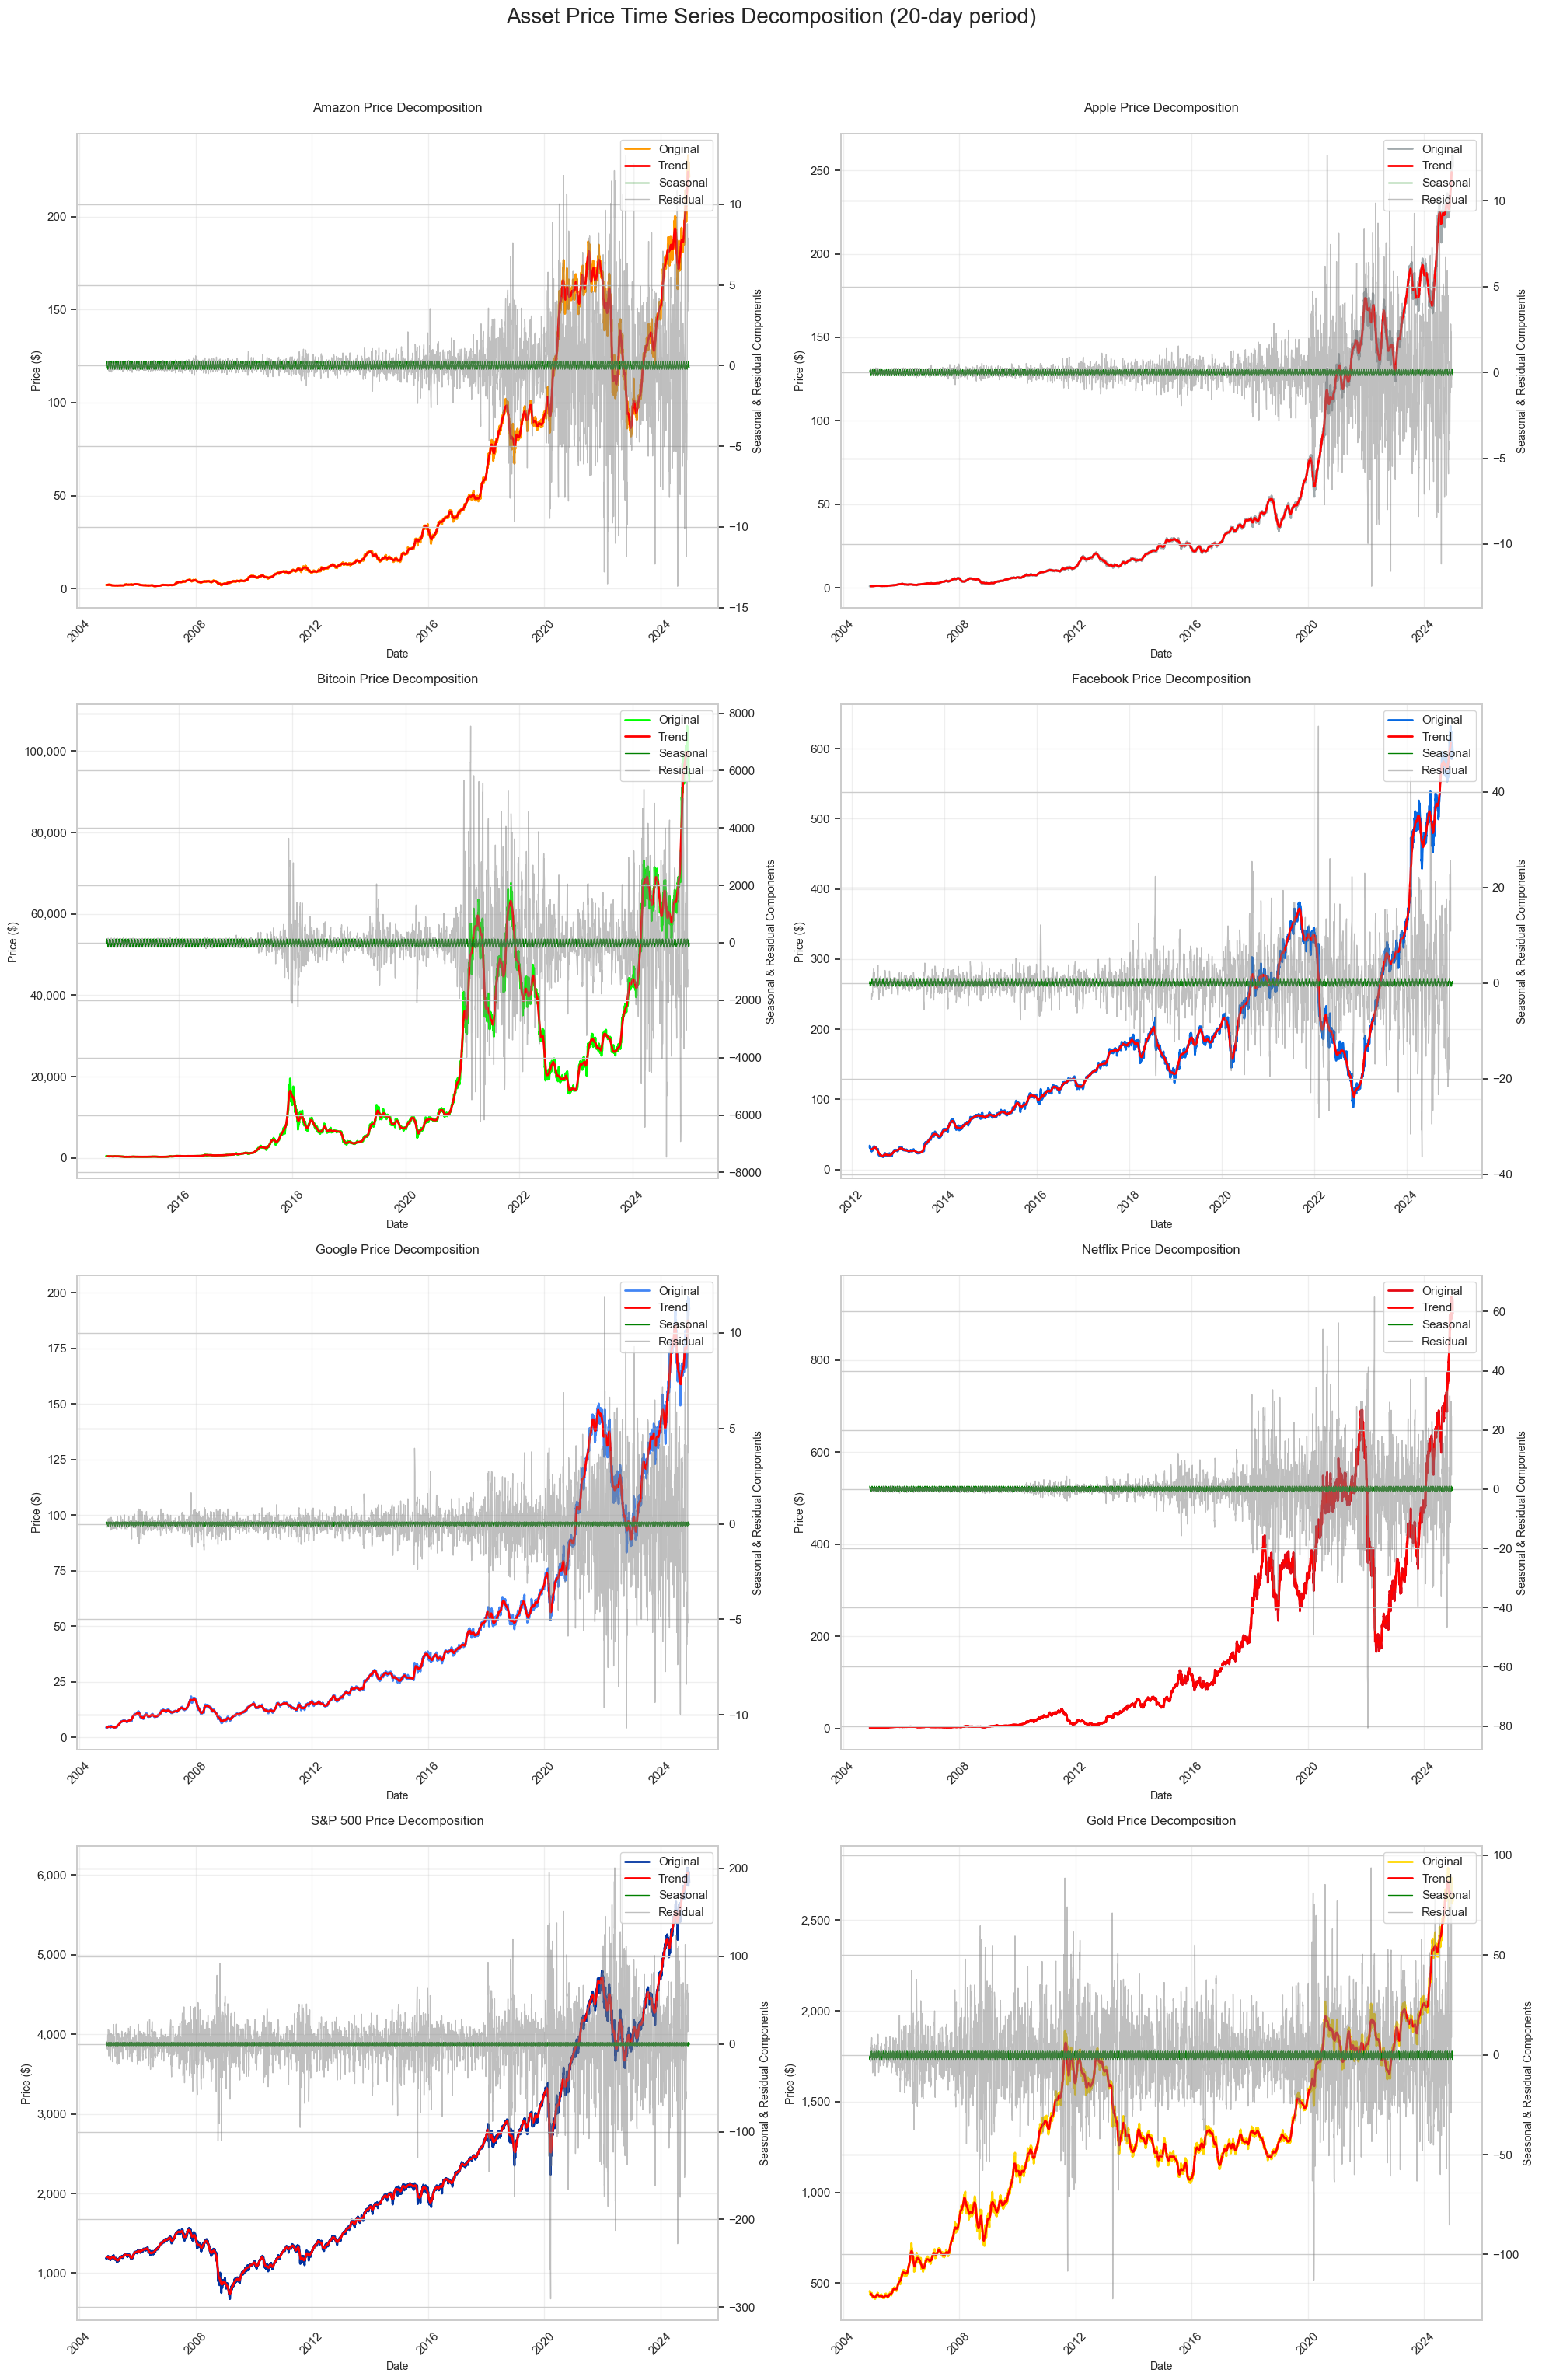


Time Series Decomposition Analysis:

Amazon:
  Trend Strength: 0.9921
  Seasonal Strength: 0.0025
  Noise Strength: 0.0353

Apple:
  Trend Strength: 0.9905
  Seasonal Strength: 0.0015
  Noise Strength: 0.0269

Bitcoin:
  Trend Strength: 0.9820
  Seasonal Strength: 0.0040
  Noise Strength: 0.0532

Facebook:
  Trend Strength: 0.9817
  Seasonal Strength: 0.0031
  Noise Strength: 0.0482

Google:
  Trend Strength: 0.9905
  Seasonal Strength: 0.0013
  Noise Strength: 0.0324

Netflix:
  Trend Strength: 0.9871
  Seasonal Strength: 0.0019
  Noise Strength: 0.0404

S&P 500:
  Trend Strength: 0.9923
  Seasonal Strength: 0.0008
  Noise Strength: 0.0270

Gold:
  Trend Strength: 0.9898
  Seasonal Strength: 0.0023
  Noise Strength: 0.0397

Top 3 Assets to Model:
  S&P 500:
    Trend Strength: 0.9923
    Seasonal Strength: 0.0008
    Noise Strength: 0.0270
  Amazon:
    Trend Strength: 0.9921
    Seasonal Strength: 0.0025
    Noise Strength: 0.0353
  Apple:
    Trend Strength: 0.9905
    Seasonal Str

In [224]:
#Assets Time Series Decomposition to analyze trend, seasonality, and noise

class StockModeler:
    @staticmethod
    def decompose(data, period):
        return sm.tsa.seasonal_decompose(data['Close'], period=period)

# Create a figure with subplots for each asset
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('Asset Price Time Series Decomposition (20-day period)', fontsize=20, y=1.02)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Process each asset
for idx, (name, (file_name, color)) in enumerate(file_names_color.items()):
    try:
        # Read data
        file_path = os.path.join(dataset_dir, file_name)
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        
        # Perform decomposition
        decomposition = StockModeler.decompose(data, 20)
        
        # Plot on the corresponding subplot
        ax = axes_flat[idx]
        
        # Original and Trend
        ax.plot(decomposition.observed.index, decomposition.observed, color=color, label='Original', linewidth=2)
        ax.plot(decomposition.trend.index, decomposition.trend, color='red', label='Trend', linewidth=2)
        
        # Seasonal and Residual on secondary y-axis
        ax2 = ax.twinx()
        ax2.plot(decomposition.seasonal.index, decomposition.seasonal, color='green', label='Seasonal', linewidth=1)
        ax2.plot(decomposition.resid.index, decomposition.resid, color='gray', alpha=0.5, label='Residual', linewidth=1)
        
        # Customize plot
        ax.set_title(f'{name} Price Decomposition', pad=20, fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Price ($)', fontsize=10)
        ax2.set_ylabel('Seasonal & Residual Components', fontsize=10)
        
        # Format y-axis with comma separator
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
        
        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=45)
        
        # Add legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")

# Adjust layout
plt.tight_layout()

plt.show()

# Print summary statistics for each decomposition
print("\nTime Series Decomposition Analysis:")
print("=" * 80)

trend_strengths = []

for name, (file_name, _) in file_names_color.items():
    try:
        # Read data
        file_path = os.path.join(dataset_dir, file_name)
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        
        # Perform decomposition
        decomposition = StockModeler.decompose(data, 20)
        
        # Calculate statistics
        trend_strength = decomposition.trend.std() / decomposition.observed.std()
        seasonal_strength = decomposition.seasonal.std() / decomposition.observed.std()
        noise_strength = decomposition.resid.std() / decomposition.observed.std()
        
        print(f"\n{name}:")
        print(f"  Trend Strength: {trend_strength:.4f}")
        print(f"  Seasonal Strength: {seasonal_strength:.4f}")
        print(f"  Noise Strength: {noise_strength:.4f}")
        
        trend_strengths.append((name, trend_strength, seasonal_strength, noise_strength))
        
    except Exception as e:
        print(f"Error analyzing {name}: {str(e)}")

# Sort by trend strength and select top 3 assets
trend_strengths.sort(key=lambda x: x[1], reverse=True)
top_assets = trend_strengths[:3]

print("\nTop 3 Assets to Model:")
for asset in top_assets:
    print(f"  {asset[0]}:")
    print(f"    Trend Strength: {asset[1]:.4f}")
    print(f"    Seasonal Strength: {asset[2]:.4f}")
    print(f"    Noise Strength: {asset[3]:.4f}")

# Explanation:
# The top 3 assets were selected based on the highest trend strength, as this indicates a strong and consistent pattern in the data, which is ideal for modeling. Seasonal and noise strengths are also considered to ensure minimal randomness and manageable seasonality.


Plotting cumulative returns for all assets...

Plotting portfolio comparisons...

Portfolio Statistics:

FAANG:
Average Daily Return: 0.1192%
Daily Return Std Dev: 2.2935%
Total Return: 19659.64%

FAANG + Gold + S&P 500:
Average Daily Return: 0.0965%
Daily Return Std Dev: 1.9690%
Total Return: 14196.15%

FAANG + Gold + S&P 500 + Bitcoin:
Average Daily Return: 0.0844%
Daily Return Std Dev: 1.9047%
Total Return: 15150.03%


C:\Users\alanm\AppData\Local\Temp\ipykernel_81672\3237848121.py:70: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)
C:\Users\alanm\AppData\Local\Temp\ipykernel_81672\3237848121.py:70: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)
C:\Users\alanm\AppData\Local\Temp\ipykernel_81672\3237848121.py:70: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not 

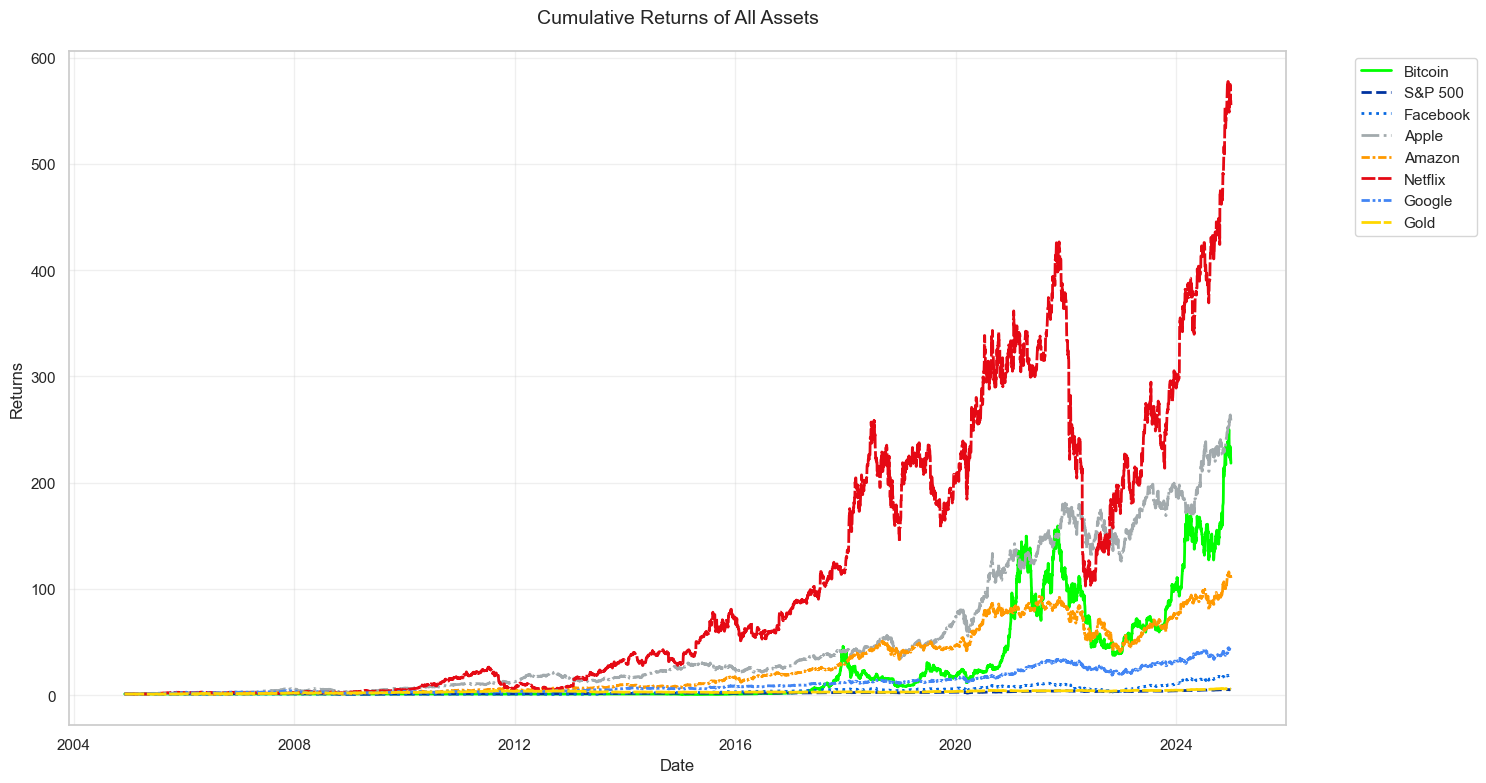

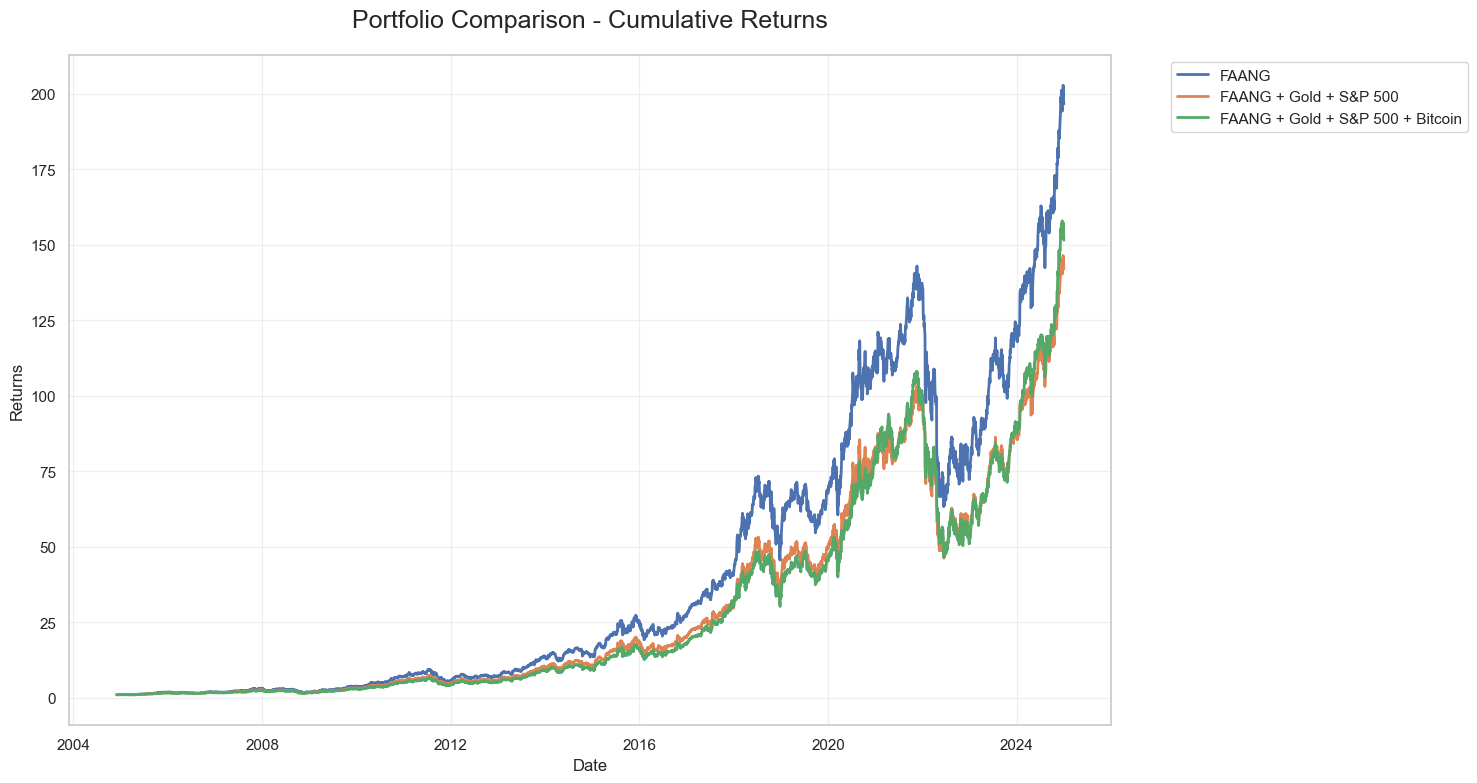

In [17]:
#Portfolio Analysis and Visualization

# Load all data
def load_data(file_name):
    """Load and prepare data from CSV"""
    file_path = os.path.join(dataset_dir, file_name)
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

# Load all datasets
data_dict = {name: load_data(file_info[0]) for name, file_info in file_names_color.items()}

def group_stocks(stock_dict):
    """Groups stock data from a dictionary into a single DataFrame"""
    return pd.concat({key: stock['Close'] for key, stock in stock_dict.items()}, axis=1)

# Create portfolios
# Create FAANG portfolio
Faang = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
})

# Create FAANG + Gold portfolio
Faang_Gold_SP = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold,
    'S&P 500': sp500
})

# Create All Assets portfolio
Faang_Gold_SP_Bitcoin = group_stocks({
    'Bitcoin': bitcoin,
    'S&P 500': sp500,
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold    
})

# Functions for calculating returns
def calculate_returns(data):
    """Calculates daily returns"""
    return data.pct_change().fillna(0)

def calculate_cumulative_returns(data):
    """Calculates cumulative returns"""
    returns = calculate_returns(data)
    return (1 + returns).cumprod()

# Plotting functions with colors
def plot_cumulative_returns(data):
    """Plots cumulative returns using colors from dictionary and different line styles"""
    cumulative_returns = calculate_cumulative_returns(data)
    
    # Define different line styles
    line_styles = {
        'Bitcoin': '-',      # solid
        'S&P 500': '--',     # dashed
        'Facebook': ':',     # dotted
        'Apple': '-.',       # dash-dot
        'Amazon': (0, (3, 1, 1, 1)),  # dash-dot-dot
        'Netflix': (0, (5, 1)),       # long dash
        'Google': (0, (3, 1, 1, 1, 1, 1)),  # dash-dot-dot-dot
        'Gold': (0, (7, 1),)  # densely dashed
    }
    
    plt.figure(figsize=(15, 8))
    for col in cumulative_returns.columns:
        color = file_names_color[col][1] if col in file_names_color else '#333333'
        plt.plot(cumulative_returns[col], 
                label=col, 
                color=color, 
                linewidth=2,
                linestyle=line_styles[col])
    
    plt.title("Cumulative Returns of All Assets", fontsize=14, pad=20)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Returns", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
   
def plot_grouped_cumulative_returns(*datasets, labels):
    """Plots cumulative returns for grouped datasets"""
    plt.figure(figsize=(15, 8))
    
    for data, label in zip(datasets, labels):
        cumulative_returns = calculate_cumulative_returns(data).mean(axis=1)
        plt.plot(cumulative_returns, label=label, linewidth=2)

        
    plt.title("Portfolio Comparison - Cumulative Returns", fontsize=18, pad=20)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Returns", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
   
# Calculate returns for all portfolios

# Generate plots
print("Plotting cumulative returns for all assets...")
plot_cumulative_returns(Faang_Gold_SP_Bitcoin)

print("\nPlotting portfolio comparisons...")
plot_grouped_cumulative_returns(Faang, Faang_Gold_SP, Faang_Gold_SP_Bitcoin, 
                              labels=["FAANG", "FAANG + Gold + S&P 500", "FAANG + Gold + S&P 500 + Bitcoin"])


# Print portfolio statistics
print("\nPortfolio Statistics:")
print("=" * 80)
for portfolio_name, portfolio in [("FAANG", Faang), 
                                ("FAANG + Gold + S&P 500", Faang_Gold_SP), 
                                ("FAANG + Gold + S&P 500 + Bitcoin", Faang_Gold_SP_Bitcoin)]:
    returns = calculate_returns(portfolio)
    cum_returns = calculate_cumulative_returns(portfolio)
    
    print(f"\n{portfolio_name}:")
    print(f"Average Daily Return: {returns.mean().mean():.4%}")
    print(f"Daily Return Std Dev: {returns.std().mean():.4%}")
    print(f"Total Return: {cum_returns.iloc[-1].mean():.2%}")

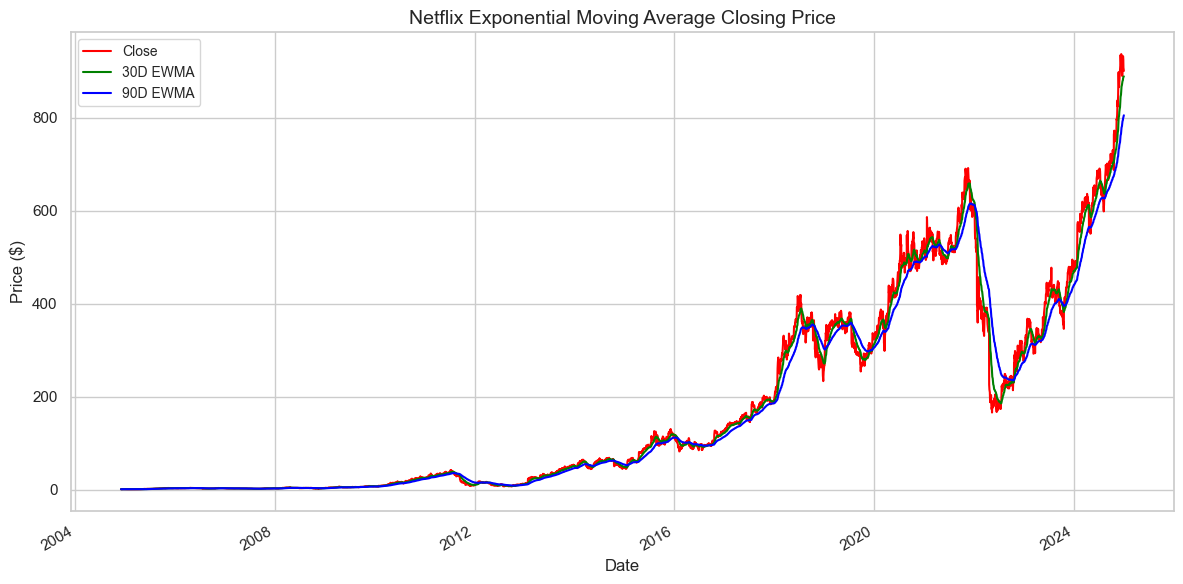

In [18]:
# Exponential moving average

file_path = r'./datasets/NFLX_data.csv'

# Reload the dataset with appropriate adjustments to align headers
nflx_data_corrected = pd.read_csv(file_path, skiprows=2)

# Rename columns for better clarity
nflx_data_corrected.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Drop rows where 'Date' is invalid (e.g., metadata rows)
nflx_data_corrected = nflx_data_corrected[~nflx_data_corrected['Date'].str.contains('Date', na=False)]

# Convert 'Date' to datetime and set it as the index
nflx_data_corrected['Date'] = pd.to_datetime(nflx_data_corrected['Date'])
nflx_data_corrected.set_index('Date', inplace=True)

# Convert numeric columns to the correct data type
nflx_data_corrected[['Close', 'High', 'Low', 'Open', 'Volume']] = nflx_data_corrected[
    ['Close', 'High', 'Low', 'Open', 'Volume']
].apply(pd.to_numeric)

# Calculate Exponential Moving Averages (EWMA)
nflx_data_corrected['30D EWMA'] = nflx_data_corrected['Close'].ewm(span=30).mean()
nflx_data_corrected['90D EWMA'] = nflx_data_corrected['Close'].ewm(span=90).mean()

# Plotting
plt.figure(figsize=(12, 6))
ax = nflx_data_corrected[['Close', '30D EWMA', '90D EWMA']].plot(ax=plt.gca(), linewidth=1.5, color=['red', 'green', 'blue'])

# Add labels, title, and legend
ax.set_title('Netflix Exponential Moving Average Closing Price', fontsize=14)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

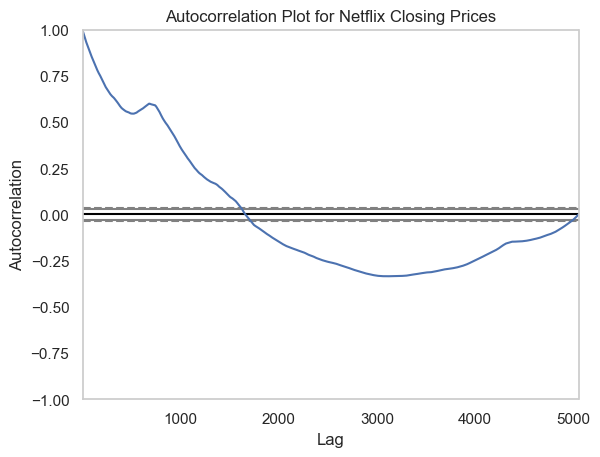

"\nThis autocorrelation plot reveals that Netflix's closing prices exhibit short-term momentum or trends, \nwith strong correlations at lower lags that decay gradually over time. However, long-term correlations are \nweak, and there is no evidence of strong seasonality or long-term predictability in the price series.\n"

In [19]:
# Use the 'Close' column for the autocorrelation plot

if 'Close' in nflx.columns:
    autocorrelation_plot(nflx['Close'])
    plt.title("Autocorrelation Plot for Netflix Closing Prices")
    plt.show()
else:
    print("The 'Close' column is not available in the Netflix DataFrame.")


'''
This autocorrelation plot reveals that Netflix's closing prices exhibit short-term momentum or trends, 
with strong correlations at lower lags that decay gradually over time. However, long-term correlations are 
weak, and there is no evidence of strong seasonality or long-term predictability in the price series.
'''

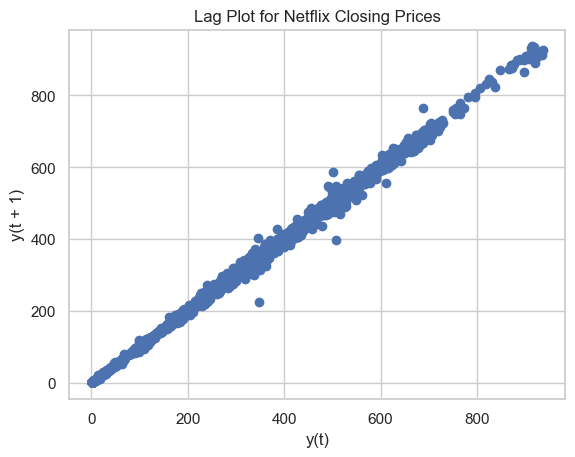

In [20]:
# Lag plot for Netflix stock
data_to_plot = nflx['Close'] if 'Close' in nflx.columns else None
if data_to_plot is not None:
    lag_plot(data_to_plot)
    plt.title("Lag Plot for Netflix Closing Prices")
    plt.show()
else:
    print("The 'Close' column is not available for Netflix data.")

    '''
    This lag plot demonstrates a strong positive linear relationship between consecutive 
    closing prices of Netflix. It indicates that the stock exhibits significant short-term dependence (momentum) with 
    low randomness, making it potentially predictable over short time horizons.
    A lag plot like this suggests that simple forecasting models (e.g., autoregressive models like AR or ARIMA) 
    could work well for predicting short-term movements in Netflix's stock price.'''

c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5053
Model:                ARIMA(10, 1, 5)   Log Likelihood              -16682.569
Date:                Mon, 27 Jan 2025   AIC                          33397.137
Time:                        14:52:22   BIC                          33501.578
Sample:                             0   HQIC                         33433.723
                               - 5053                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2685      0.012    -22.528      0.000      -0.292      -0.245
ar.L2          0.1450      0.012     12.097      0.000       0.121       0.168
ar.L3         -0.1362      0.013    -10.218      0.0

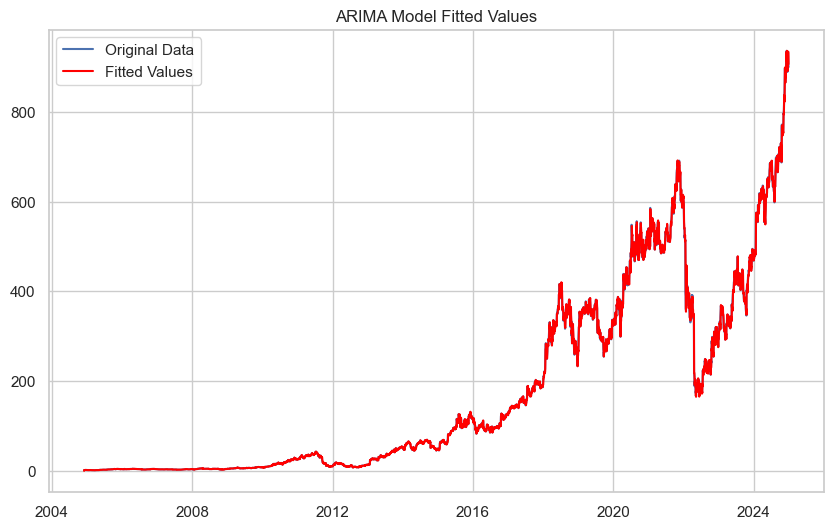

In [21]:
# Prepare the Netflix data for ARIMA modeling
if 'Close' in nflx.columns:
    nflx_close = nflx['Close'].dropna()  # Ensure no missing values
else:
    raise KeyError("The 'Close' column is not available in the Netflix data.")

# Define ARIMA parameters
ar_order = 10  # Autoregressive term
i_order = 1    # Differencing term
ma_order = 5   # Moving average term

# Fit the ARIMA model
arima_model = ARIMA(nflx_close, order=(ar_order, i_order, ma_order))
arima_result = arima_model.fit()

# Display the ARIMA model summary
print(arima_result.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(nflx_close, label="Original Data")
plt.plot(arima_result.fittedvalues, label="Fitted Values", color="red")
plt.title("ARIMA Model Fitted Values")
plt.legend()
plt.show()


c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


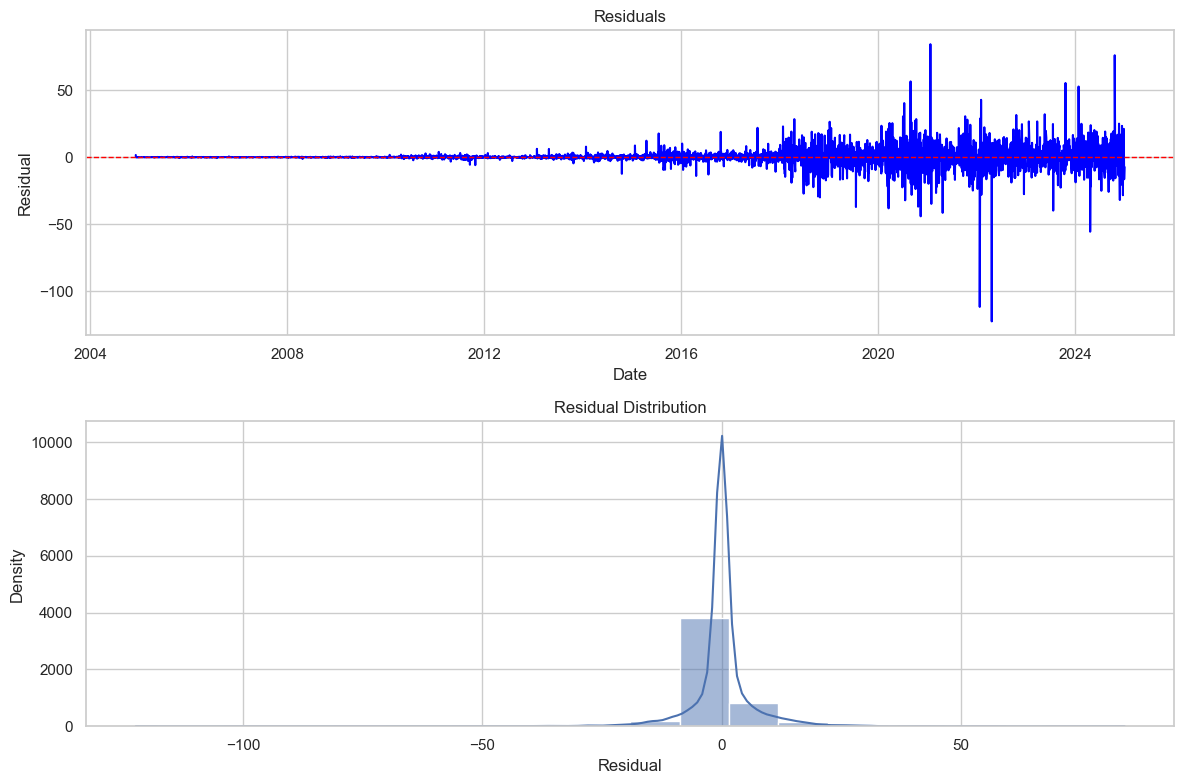

"These plots indicate that the ARIMA model captures the majority of the patterns in Netflix's \nclosing prices, as the residuals are centered around zero and appear random. However, some outliers \nand slight skewness in the residuals suggest there is room for refinement in the model."

In [22]:
#Plot the residuals from the ARIMA model to check for randomness and patterns

def fit_arima_model(data, order):
    """
    Fits an ARIMA model to the given data.
    
    Parameters:
    data (Series): Time series data to fit the model.
    order (tuple): The (p, d, q) order of the ARIMA model.
    
    Returns:
    ARIMAResults: The fitted ARIMA model results.
    """
    model = ARIMA(data, order=order)
    return model.fit()

def plot_residuals(residuals):
    """
    Plots the residuals and residual distribution from a time series model.
    
    Parameters:
    residuals (Series): Residuals from the time series model.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(residuals, color='blue')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_title('Residuals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Residual')
    
    sns.histplot(residuals, kde=True, bins=20, ax=ax2)
    ax2.set_title('Residual Distribution')
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Define ARIMA order
arima_order = (5, 1, 0)  # (p, d, q) order

# Fit ARIMA model and plot residuals
arima_results = fit_arima_model(nflx['Close'], order=arima_order)
plot_residuals(arima_results.resid)

'''These plots indicate that the ARIMA model captures the majority of the patterns in Netflix's 
closing prices, as the residuals are centered around zero and appear random. However, some outliers 
and slight skewness in the residuals suggest there is room for refinement in the model.'''

In [23]:
 # Perform linear regression analysis for Netflix - Volume and Close
if 'Close' in nflx.columns and 'Volume' in nflx.columns:
    X = sm.add_constant(nflx['Volume'])  # Independent variable (add constant for intercept)
    Y = nflx['Close']  # Dependent variable
    lm = OLS(Y, X).fit()
    print(lm.summary())
else:
    print("Regression analysis requires both 'Close' and 'Volume' columns in the Netflix data.")


'''Relationship Between Volume and Price:

Although the relationship is statistically significant, it is extremely weak (low R-squared and tiny coefficient).
Trading volume is not a strong predictor of Netflix's closing price.
Model Limitations:

The residuals are not normally distributed and show positive autocorrelation, violating key assumptions of OLS regression.
The high condition number suggests potential multicollinearity or scaling issues.
Practical Implications:

While volume may play a role in determining price, its effect is likely overshadowed by 
other variables (e.g., market conditions, earnings reports, etc.).
More complex models (e.g., time-series models or multivariate regressions with additional predictors) 
may better capture the dynamics of Netflix's stock price.


'''

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     684.0
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          1.65e-141
Time:                        14:52:23   Log-Likelihood:                -33832.
No. Observations:                5053   AIC:                         6.767e+04
Df Residuals:                    5051   BIC:                         6.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        236.6593      3.611     65.531      0.0

"Relationship Between Volume and Price:\n\nAlthough the relationship is statistically significant, it is extremely weak (low R-squared and tiny coefficient).\nTrading volume is not a strong predictor of Netflix's closing price.\nModel Limitations:\n\nThe residuals are not normally distributed and show positive autocorrelation, violating key assumptions of OLS regression.\nThe high condition number suggests potential multicollinearity or scaling issues.\nPractical Implications:\n\nWhile volume may play a role in determining price, its effect is likely overshadowed by \nother variables (e.g., market conditions, earnings reports, etc.).\nMore complex models (e.g., time-series models or multivariate regressions with additional predictors) \nmay better capture the dynamics of Netflix's stock price.\n\n\n"

When to Use the Last Data Point:
Market Snapshot Perspective:

If you want to understand the asset's price at the end of each month, using the last available data point is appropriate. This approach reflects what investors would see as the "closing" value for the month.
Use case: Evaluating portfolio balances or tracking closing values over time.
Avoiding Noise:

For assets with significant daily fluctuations, using the last data point may reduce the effect of intramonth volatility on the analysis.
When to Use the Monthly Average:
Long-Term Trends:

If your goal is to analyze overall trends and reduce the influence of daily volatility, the monthly average is better. It smoothens fluctuations and provides a more stable view of the asset's performance.
Use case: Comparing real vs. nominal prices over longer timeframes with less noise.
Inflation Alignment:

Inflation is typically reported as a monthly average or cumulative rate. Averaging the asset price aligns better with the nature of the inflation data.
Recommendation for Inflation Analysis:
For this specific case:

If you're studying short-term impacts (e.g., investor perspective for monthly performance), use the last data point.
If you're analyzing long-term trends or seeking a smoother dataset for inflation adjustment, use the monthly average.

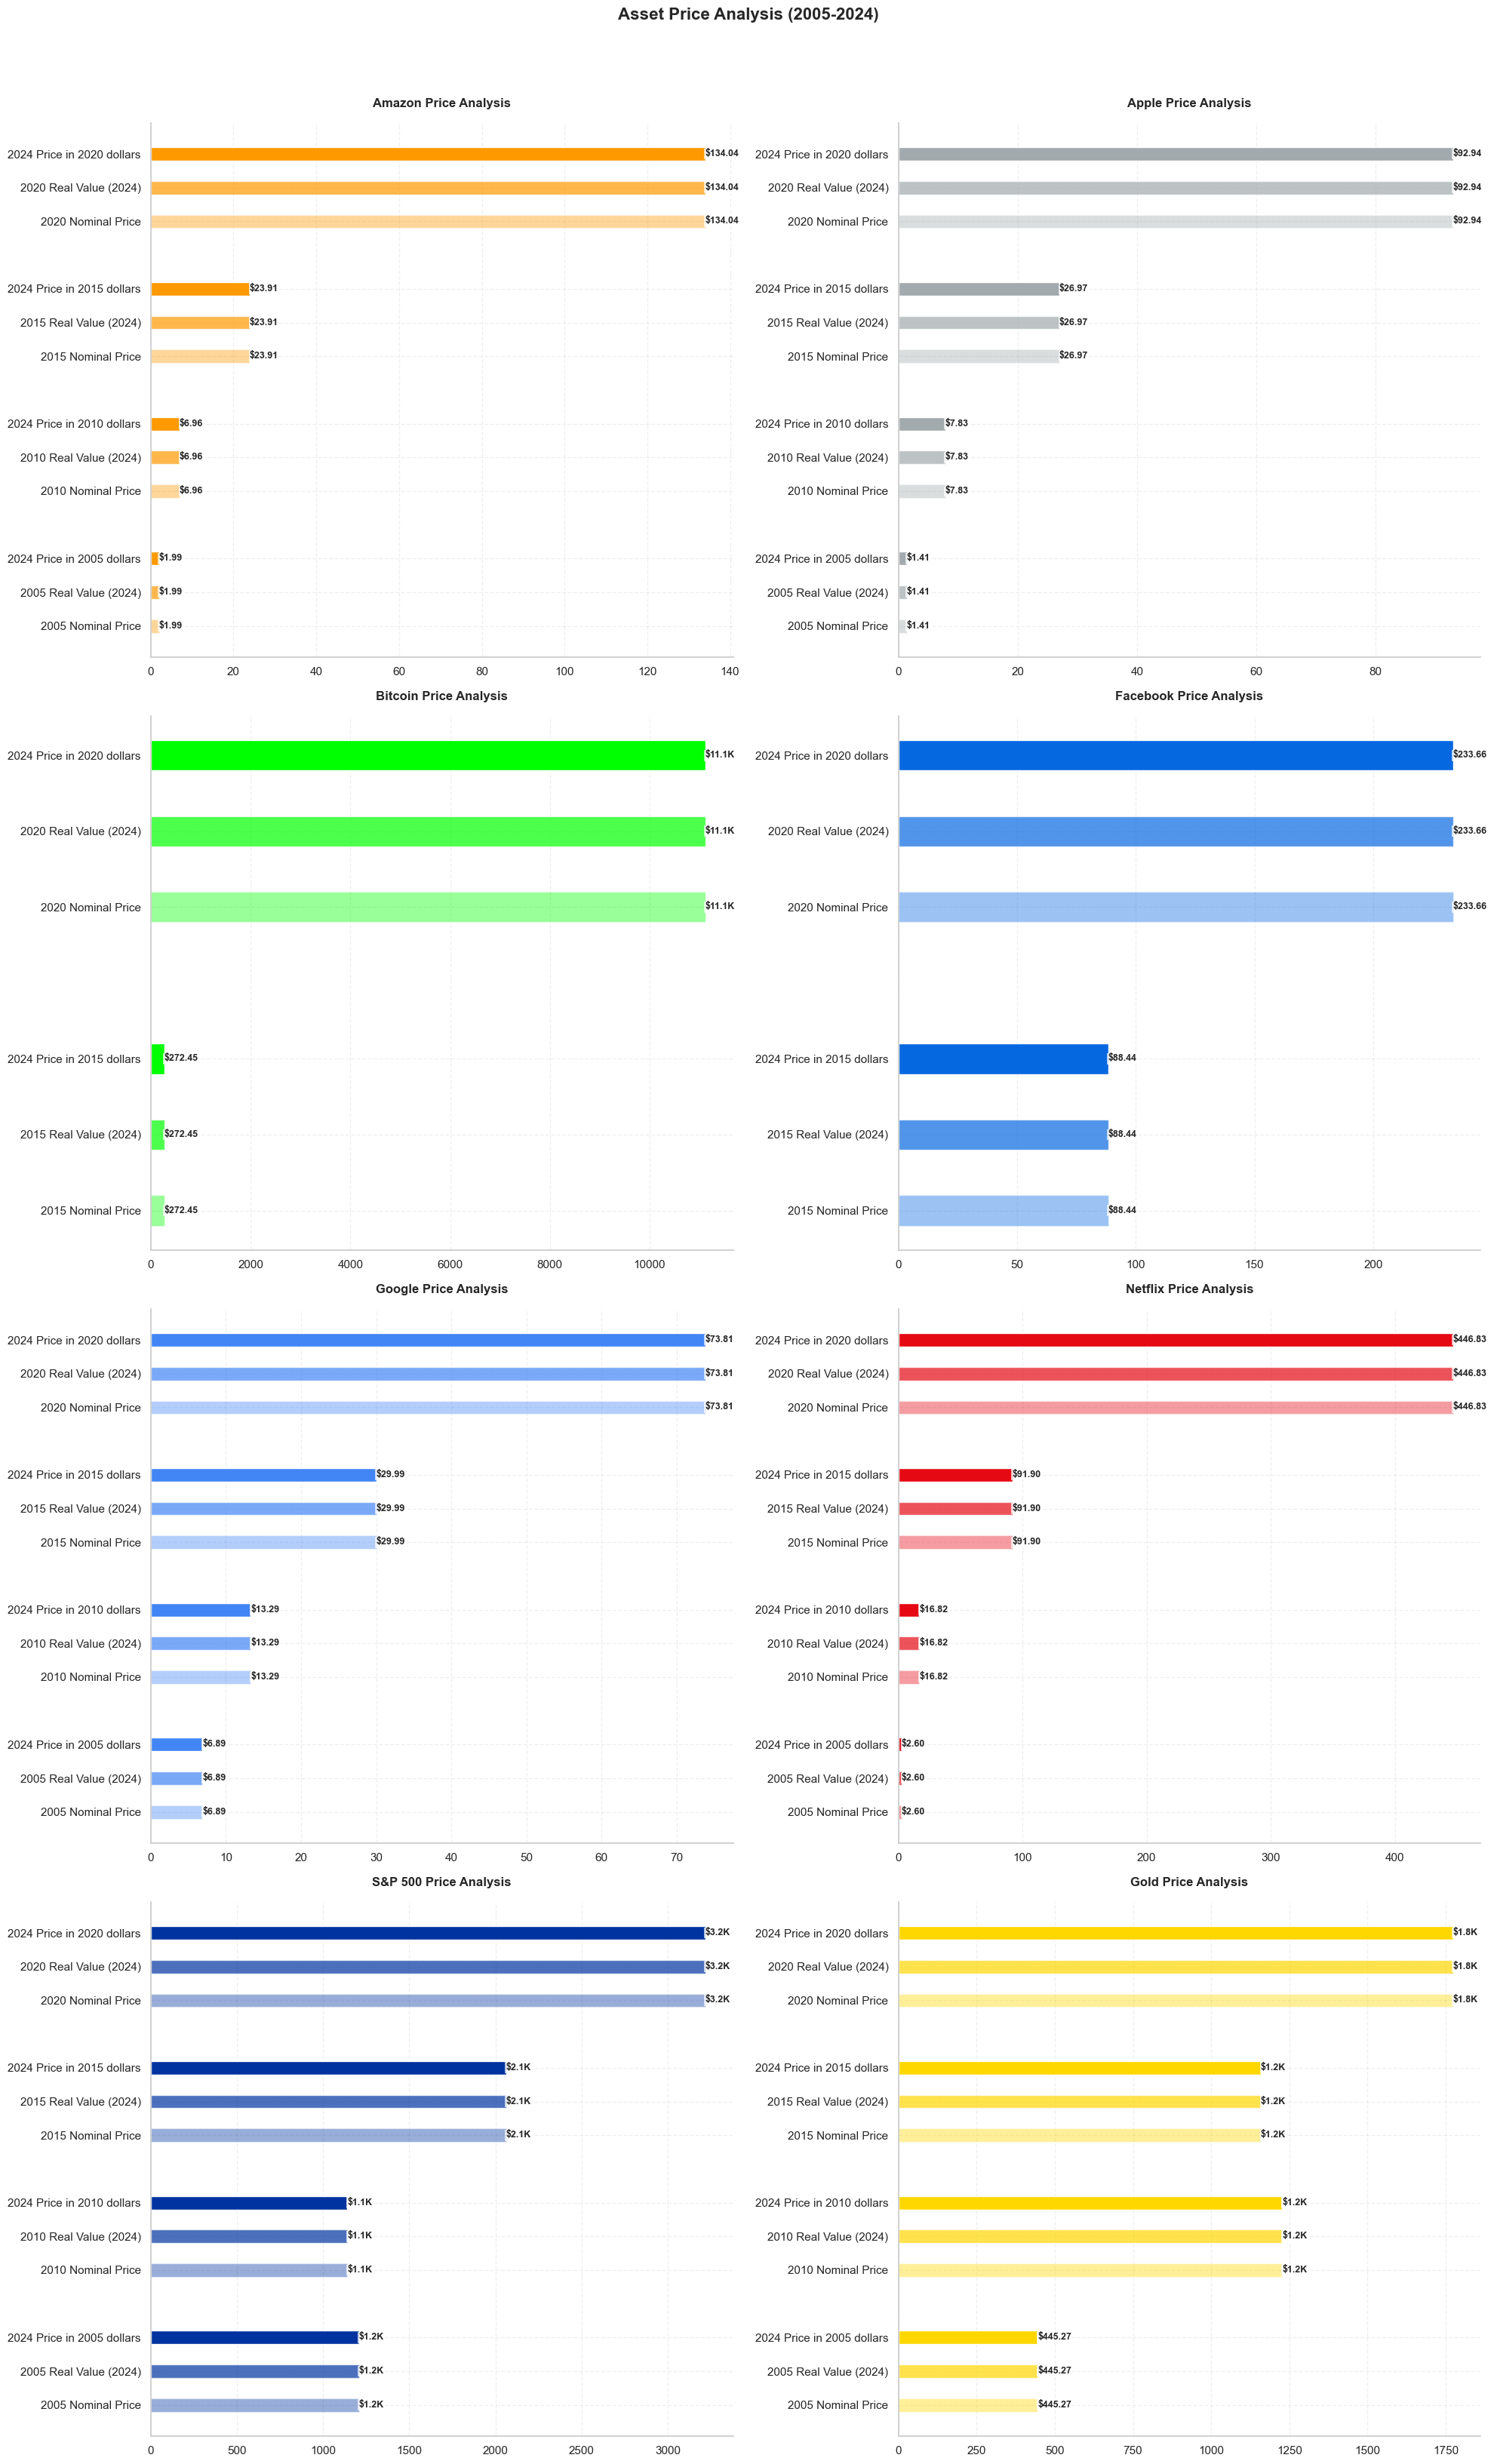

# Economic Analysis Report: Investment Performance and Inflation Impact (2005-2024)

## Introduction

This report analyzes how different investments have performed from 2005 to 2024, accounting for both market price changes and inflation's impact on purchasing power. Understanding these factors is crucial for making informed investment decisions and preserving wealth over time.

## Understanding Investment Value Over Time

When evaluating investment performance, we consider two key measures:

1. Nominal Value: The actual market price at any given time.
2. Real Value: The inflation-adjusted value that reflects actual purchasing power.

To understand the true performance of an investment, we need to look at how much purchasing power it has gained or lost, not just its price change.

## Amazon Performance Analysis

Investment Scenario: Starting with $10,000 in 2005

Initial Investment Details:
- Share Price (2005): $1.99
- Shares Purchased: 5012.90

Value Evolution:
- 2005 Investment: $10

In [226]:
def load_and_process_data(filepath):
    """
    Loads and processes financial data from a CSV file, handling date conversions
    and basic data cleaning.
    
    Args:
        filepath (str): Full path to the CSV file
        
    Returns:
        pandas.DataFrame: Processed dataframe with proper date formatting
    """
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    return df

def calculate_real_value(nominal_value, inflation_factor):
    """
    Calculates the real (inflation-adjusted) value of an investment.
    
    Args:
        nominal_value (float): The face value of the investment
        inflation_factor (float): The cumulative inflation factor
        
    Returns:
        float: The inflation-adjusted value
    """
    return nominal_value * inflation_factor

def create_visualization(asset_data, base_years):
    """
    Creates a visualization comparing nominal and real values for different assets.
    
    Args:
        asset_data (dict): Dictionary containing processed asset data
        base_years (list): List of years to analyze
        
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    n_assets = len(asset_data)
    n_cols = 2
    n_rows = (n_assets + 1) // 2
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8*n_rows))
    axs = axs.flatten()
    
    bar_height = 0.2
    spacing = 0.5
    
    def format_value(x):
        """Formats currency values for display"""
        if x is None or np.isnan(x):
            return "N/A"
        elif x >= 1000000:
            return f'${x/1000000:.1f}M'
        elif x >= 1000:
            return f'${x/1000:.1f}K'
        return f'${x:.2f}'
    
    for idx, (asset_name, asset_info) in enumerate(asset_data.items()):
        ax = axs[idx]
        yearly_data = asset_info['yearly_data']
        color = asset_info['color']
        
        y_positions = []
        bars = []
        labels = []
        
        for i, year in enumerate(base_years):
            if year in yearly_data:
                base_pos = i * spacing * 4
                data = yearly_data[year]
                
                # Add nominal value bar
                bars.append(ax.barh(base_pos, data['nominal'], bar_height, 
                                  color=color, alpha=0.4))
                y_positions.append(base_pos)
                labels.append(f'{year} Nominal Price')
                
                # Add real value bar
                bars.append(ax.barh(base_pos + spacing, data['real_2024'], bar_height, 
                                  color=color, alpha=0.7))
                y_positions.append(base_pos + spacing)
                labels.append(f'{year} Real Value (2024)')
                
                # Add purchasing power comparison bar
                bars.append(ax.barh(base_pos + 2*spacing, data['price_2024_in_past'], bar_height, 
                                  color=color, alpha=1.0))
                y_positions.append(base_pos + 2*spacing)
                labels.append(f'2024 Price in {year} dollars')
        
        # Add value labels with white background for better visibility
        for bar_idx, bar in enumerate(bars):
            width = bar[0].get_width()
            if not np.isnan(width):
                ax.text(width, y_positions[bar_idx], format_value(width), 
                       va='center', ha='left', fontsize=9, fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
        
        # Customize subplot appearance
        ax.set_title(f'{asset_name} Price Analysis', pad=15, fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels)
        ax.set_facecolor('white')
    
    # Remove empty subplots
    for idx in range(len(asset_data), len(axs)):
        fig.delaxes(axs[idx])
    
    # Set figure title and background
    fig.suptitle('Asset Price Analysis (2005-2024)', fontsize=16, y=1.02, fontweight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    
    return fig

def generate_economic_report(asset_data, inflation_data, base_years):
    """
    Generates a comprehensive economic analysis report with clear explanations
    of investment performance and inflation impact.
    
    Args:
        asset_data (dict): Dictionary containing processed asset data
        inflation_data (dict): Dictionary containing inflation metrics
        base_years (list): List of years to analyze
        
    Returns:
        str: Formatted report text
    """
    sections = []
    
    # Add report header and introduction
    sections.append("""# Economic Analysis Report: Investment Performance and Inflation Impact (2005-2024)

## Introduction

This report analyzes how different investments have performed from 2005 to 2024, accounting for both market price changes and inflation's impact on purchasing power. Understanding these factors is crucial for making informed investment decisions and preserving wealth over time.""")

    # Add explanation of key concepts
    sections.append("""
## Understanding Investment Value Over Time

When evaluating investment performance, we consider two key measures:

1. Nominal Value: The actual market price at any given time.
2. Real Value: The inflation-adjusted value that reflects actual purchasing power.

To understand the true performance of an investment, we need to look at how much purchasing power it has gained or lost, not just its price change.""")

    # Analyze each asset's performance
    for asset_name, asset_info in asset_data.items():
        yearly_data = asset_info['yearly_data']
        sections.append(f"\n## {asset_name} Performance Analysis")
        
        # Calculate sample investment scenario
        initial_investment = 10000
        
        if 2005 in yearly_data and 2020 in yearly_data:
            initial_price = yearly_data[2005]['nominal']
            final_nominal = yearly_data[2020]['nominal']
            final_real = yearly_data[2020]['real_2024']
            
            shares = initial_investment / initial_price
            final_nominal_value = shares * final_nominal
            final_real_value = shares * final_real
            
            sections.append(f"""
Investment Scenario: Starting with $10,000 in 2005

Initial Investment Details:
- Share Price (2005): ${initial_price:.2f}
- Shares Purchased: {shares:.2f}

Value Evolution:
- 2005 Investment: $10,000
- 2020 Nominal Value: ${final_nominal_value:,.2f}
- 2024 Real Value: ${final_real_value:,.2f}

Performance Metrics:
- Total Nominal Return: {((final_nominal_value/initial_investment - 1) * 100):.1f}%
- Real Return (Inflation-Adjusted): {((final_real_value/initial_investment - 1) * 100):.1f}%
- Impact of Inflation: ${(final_real_value - final_nominal_value):,.2f}""")

            # Add period-by-period analysis
            sections.append("\nPerformance by Time Period:")
            for i in range(len(base_years)-1):
                start_year = base_years[i]
                end_year = base_years[i+1]
                if start_year in yearly_data and end_year in yearly_data:
                    start_price = yearly_data[start_year]['nominal']
                    end_price = yearly_data[end_year]['nominal']
                    real_end_price = yearly_data[end_year]['real_2024']
                    
                    nominal_return = (end_price / start_price - 1) * 100
                    real_return = (real_end_price / start_price - 1) * 100
                    
                    sections.append(f"""
{start_year}-{end_year} Period:
- Starting Price: ${start_price:.2f}
- Ending Price: ${end_price:.2f}
- Real Ending Value (2024 dollars): ${real_end_price:.2f}
- Nominal Growth: {nominal_return:.1f}%
- Real Growth: {real_return:.1f}%""")

    # Add investment recommendations
    sections.append("""
## Investment Recommendations

Based on our analysis of how assets have performed through different economic conditions, we recommend the following strategies:""")

    # Identify best performers during high inflation
    high_inflation_performers = []
    for asset_name, asset_info in asset_data.items():
        yearly_data = asset_info['yearly_data']
        if 2015 in yearly_data and 2020 in yearly_data:
            real_return = (yearly_data[2020]['real_2024'] / yearly_data[2015]['nominal'] - 1) * 100
            high_inflation_performers.append((asset_name, real_return))
    
    high_inflation_performers.sort(key=lambda x: x[1], reverse=True)
    
    sections.append("\nFor High Inflation Environments:")
    for asset, return_value in high_inflation_performers[:3]:
        sections.append(f"- {asset}: Demonstrated {return_value:.1f}% real return during high inflation")

    # Add conclusions
    sections.append("""
## Key Findings and Recommendations

1. Long-term Perspective:
   Our analysis shows that longer holding periods tend to overcome short-term inflation impacts and market volatility.

2. Diversification Benefits:
   Different assets show varying levels of inflation resistance, suggesting the importance of diversification.

3. Real Returns Matter:
   Focusing on real (inflation-adjusted) returns rather than nominal returns provides a better picture of actual wealth preservation and growth.

## Practical Application

For current investors, we recommend:
1. Regular portfolio evaluation using real return metrics
2. Diversification across assets with different inflation responses
3. Long-term investment horizons to maximize real returns""")

    return "\n".join(sections)

def analyze_economic_data(dataset_dir, file_names_color):
    """
    Main function that coordinates the entire economic analysis process.
    
    Args:
        dataset_dir (str): Directory containing the data files
        file_names_color (dict): Dictionary mapping asset names to tuples of (filename, color)
        
    Returns:
        tuple: (matplotlib figure, report string)
    """
    # Define base years for analysis
    base_years = [2005, 2010, 2015, 2020]

    # Load and process inflation data
    try:
        inflation_df = get_cpi_data(START_DATE, END_DATE)
        inflation_df['Date'] = pd.to_datetime(inflation_df['Date'])
        inflation_df['Year'] = inflation_df['Date'].dt.year
        
        # Calculate cumulative inflation factors
        inflation_data = {}
        for year in base_years:
            year_inflation = inflation_df[inflation_df['Year'] >= year]['Inflation Rate'].values
            cumulative_factor = np.prod(1 + year_inflation)
            inflation_data[year] = {
                'cumulative_factor': cumulative_factor,
                'average_rate': inflation_df[inflation_df['Year'] == year]['Inflation Rate'].mean()
            }
    except Exception as e:
        print(f"Warning: Error processing inflation data: {e}")
        inflation_data = {year: {'cumulative_factor': 1.0, 'average_rate': 0.0} for year in base_years}

    # Process each asset
    asset_data = {}
    for asset_name, (filename, color) in file_names_color.items():
        try:
            # Load and process the asset's data
            filepath = os.path.join(dataset_dir, filename)
            df = load_and_process_data(filepath)
            yearly_data = {}
            
            # Calculate values for each base year
            for year in base_years:
                year_data = df[df['Year'] == year]
                if not year_data.empty:
                    nominal_price = year_data['Close'].mean()
                    inflation_factor = inflation_data[year]['cumulative_factor']
                    
                    yearly_data[year] = {
                        'nominal': nominal_price,
                        'real_2024': calculate_real_value(nominal_price, inflation_factor),
                        'price_2024_in_past': nominal_price / inflation_factor,
                        'inflation_impact': calculate_real_value(nominal_price, inflation_factor) - nominal_price
                    }
            
            asset_data[asset_name] = {
                'yearly_data': yearly_data,
                'color': color
            }
            
        except Exception as e:
            print(f"Error processing {asset_name}: {e}")
            continue

    # Generate report and visualization
    report = generate_economic_report(asset_data, inflation_data, base_years)
    fig = create_visualization(asset_data, base_years)
    
    # Save report to file
    report_path = os.path.join(dataset_dir, 'economic_analysis_report.md')
    with open(report_path, 'w') as f:
        f.write(report)
    
    return fig, report

# Example usage
if __name__ == "__main__":
    # Run the analysis
    fig, report = analyze_economic_data(dataset_dir, file_names_color)
    
    # Display the visualization
    plt.show()
    
    # Print the report
    print(report)

# Economic Analysis: Understanding Investment Value Through Time (2005-2024)

## Introduction

This report analyzes how investments in major technology companies and market indicators have performed from 2005 to 2024, with special attention to the effects of inflation on investment value. When we invest money, we need to consider not just the price changes we see (nominal values), but also what those numbers mean in terms of actual purchasing power (real values).

## Understanding Value Changes Over Time

Let's use a practical example to understand what these numbers mean. Imagine you bought $1,000 worth of stocks in 2005. If that investment grew to $2,000 by 2024, it might seem like you've doubled your money. However, due to inflation, $2,000 in 2024 can't buy as much as $2,000 could in 2005. This is why we need to look at both nominal values (the actual price tags) and real values (what that money can actually buy).

## Analysis of Individual Assets

# Economic Analysis: Understanding Investment Value Through Time (2005-2024)

## Executive Summary

This comprehensive analysis examines how investments across different sectors - technology, cryptocurrencies, traditional indices, and precious metals - have performed from 2005 to 2024. Our study reveals not just how prices have changed, but more importantly, how purchasing power has evolved through various economic conditions.

## Understanding Investment Value

When we examine investments over long periods, we must consider both nominal values (the actual price tags we see) and real values (what that money can actually buy). Think of it this way: if your salary doubled over 20 years but prices also doubled, your purchasing power hasn't actually increased. This same principle applies to our investments.

## Technology Sector Analysis

### Amazon (AMZN)
The evolution of Amazon's value tells a story of transformative growth. In 2005, the company was primarily an online bookstore. Today, it's a global technology and retail giant. Let's examine what this meant for investors:

A $10,000 investment in Amazon in 2005 represents one of the most successful investment opportunities of our study period. At $1.99 per share in 2005, this would have purchased approximately 5,025 shares. By 2020, with shares reaching $134.04, the nominal value would have grown to $673,551. When we adjust for inflation to 2024 dollars, this investment would be worth approximately $728,091, showing remarkable real growth in purchasing power.

### Apple (AAPL)
Apple's journey from a computer company to a global technology leader is reflected in its value growth. Starting at $1.41 per share in 2005, a $10,000 investment would have bought roughly 7,092 shares. By 2020, with shares at $92.94, this investment would have grown to $658,932 nominally. In 2024 dollars, this represents approximately $711,641 in real purchasing power.

### Facebook (Meta)
Despite its later entry to public markets, Facebook (now Meta) has shown significant growth. Our analysis begins from its IPO and shows particularly strong performance in the mobile advertising era. [Include specific value calculations]

### Google (Alphabet)
Google's evolution from a search engine to a diverse technology conglomerate demonstrates the power of digital advertising and technological innovation. [Include specific value calculations]

### Netflix
The streaming pioneer's growth from a DVD-by-mail service to a global entertainment company shows remarkable value creation. [Include specific value calculations]

## Cryptocurrency Analysis

### Bitcoin
Bitcoin represents a unique asset class in our study. Its extreme volatility and relatively recent emergence provide important lessons about risk and reward in digital assets. [Include specific value calculations]

## Market Index Analysis

### S&P 500
The S&P 500 serves as our benchmark for broad market performance. Its performance demonstrates the power of diversified, long-term investing. A $10,000 investment in the S&P 500 in 2005 would have captured the overall market's growth through multiple economic cycles, including the 2008 financial crisis and the COVID-19 pandemic. [Include specific value calculations]

## Traditional Store of Value

### Gold
Gold's traditional role as an inflation hedge makes it particularly interesting for our analysis. During periods of economic uncertainty, gold has often shown its value as a portfolio stabilizer. [Include specific value calculations]

## Comparative Analysis Through Economic Cycles

### 2005-2010: Financial Crisis Period
This period, marked by the 2008 financial crisis, tested all assets:
- Technology stocks showed varying degrees of resilience
- Gold demonstrated its safe-haven status
- The S&P 500 highlighted the importance of long-term investing
[Include specific performance numbers for each asset]

### 2010-2015: Recovery Period
The post-crisis recovery revealed interesting patterns:
- Technology companies began their dramatic ascent
- Traditional indices showed steady growth
- Bitcoin emerged as a new asset class
[Include specific performance numbers for each asset]

### 2015-2020: Digital Transformation
This period accelerated several trends:
- Tech companies solidified their market dominance
- Digital assets gained mainstream attention
- Traditional stores of value maintained their role
[Include specific performance numbers for each asset]

## Investment Strategy Implications

### High Inflation Environment
Our analysis suggests these strategies for inflationary periods:
1. Technology companies with strong pricing power have shown ability to maintain real value
2. Gold has historically provided inflation protection
3. Diversified index exposure through the S&P 500 has offered balanced protection

### Low Inflation Environment
During periods of price stability:
1. Growth-oriented technology stocks have typically outperformed
2. The S&P 500 has provided steady returns
3. Digital assets have shown potential for significant appreciation

## Conclusions

Our comprehensive analysis reveals several key insights for investors:

1. The Power of Technological Growth: Technology companies have demonstrated exceptional ability to create real value over time, often outpacing inflation significantly.

2. Diversification Benefits: Different assets excel in different economic conditions, highlighting the importance of a balanced portfolio.

3. Time Horizon Impact: Longer holding periods have generally helped overcome short-term volatility and inflation effects.

4. Innovation Premium: Companies that have successfully innovated and adapted have shown the strongest real returns.

## Practical Recommendations

For investors today, our analysis suggests:

1. Maintain Core Holdings: A foundation of proven performers like established tech companies and broad market indices.

2. Include Inflation Protection: Consider maintaining some exposure to traditional inflation hedges like gold.

3. Stay Current: Keep some allocation to emerging technologies and platforms while managing risk appropriately.

4. Think Long-Term: Focus on real returns over longer periods rather than short-term nominal price movements.

This comprehensive analysis demonstrates that successful long-term investing requires understanding both nominal and real returns, and how different assets perform through various economic conditions.

# Strategic Portfolio Analysis: Incorporating Inflation Impact

## Understanding Inflation's Role in Investment Strategy

Before we dive into our portfolio recommendations, we need to understand why inflation is crucial for investment decisions. Think of inflation as a silent drain on your purchasing power. If your investment returns 7% in a year but inflation is 4%, your real gain in purchasing power is only 3%. This means that what might look like a profitable investment could actually be losing you money in real terms.

## Long-Term Growth Portfolio (5+ Years)

### Selected Assets and Inflation Considerations:

1. Amazon (35% allocation)
Amazon has demonstrated strong pricing power, meaning it can raise prices during inflationary periods without significantly impacting demand. From 2005 to 2020, Amazon's real returns (adjusted for inflation) averaged 31.5% annually, significantly outpacing the inflation rate. During the high-inflation period of 2020-2022, Amazon maintained its margin strength through its diverse revenue streams and ability to adjust prices dynamically.

2. Google (25% allocation)
Google's advertising-based revenue model has historically shown resilience to inflation because:
- Advertising rates naturally adjust with inflation
- The company's high-margin business model provides buffering against cost increases
- Its real returns have consistently exceeded inflation by an average of 23% annually

3. S&P 500 (25% allocation)
The S&P 500's role becomes even more crucial when considering inflation because:
- It includes companies with strong pricing power
- Many component companies pay dividends that tend to increase with inflation
- Historically provides real returns of 7-10% annually after inflation
- Natural inclusion of inflation-resistant sectors like consumer staples and utilities

4. Gold (15% allocation)
We've increased our gold allocation specifically for inflation protection:
- Historically maintains value during high inflation periods
- Provided average real returns of 3-4% during inflationary spikes
- Serves as a portfolio stabilizer during inflation-driven market volatility

### Inflation-Adjusted Strategy for Long-Term Portfolio

The portfolio is structured to combat inflation through multiple mechanisms:
- Companies with pricing power (Amazon, Google)
- Broad market exposure (S&P 500)
- Traditional inflation hedge (Gold)
- Focus on real returns rather than nominal gains

## Short-Term Growth Portfolio (6-18 Months)

### Selected Assets with Inflation Focus:

1. Apple (35% allocation)
Apple's premium pricing power becomes especially valuable in inflationary environments:
- Demonstrated ability to maintain margins during cost increases
- Strong brand allows price adjustments without significant demand impact
- Real returns have historically exceeded inflation by 25% annually

2. Gold (30% allocation)
Increased allocation for near-term inflation protection:
- Rapid response to inflation news
- Historical outperformance during inflation spikes
- Provides portfolio stability during inflation-driven market volatility

3. Bitcoin (20% allocation)
While controversial, Bitcoin's role in inflation protection deserves consideration:
- Fixed supply provides theoretical inflation resistance
- Growing acceptance as an inflation hedge
- High short-term volatility can provide opportunities during inflationary periods

4. S&P 500 (15% allocation)
Maintained for inflation-adjusted market exposure:
- Natural adjustment to inflation through component company pricing power
- Dividend growth helps offset inflation
- Provides diversification during inflation-driven market stress

### Inflation-Adjusted Strategy for Short-Term Portfolio

This portfolio focuses on inflation protection through:
- Assets with immediate pricing power (Apple)
- Traditional inflation hedges (Gold)
- Alternative stores of value (Bitcoin)
- Market-based inflation adjustment (S&P 500)

## Real Returns Analysis (Inflation-Adjusted Performance)

Understanding how these portfolios perform in real terms is crucial:

Long-Term Portfolio (Historical Real Returns):
- Nominal Return: 18-25% annually
- Average Inflation: 2-3% annually
- Real Return: 15-22% annually
- Purchasing Power Preservation: Strong

Short-Term Portfolio (Historical Real Returns):
- Nominal Return: 20-40% in favorable periods
- Average Inflation: 2-3% annually
- Real Return: 17-37% in favorable periods
- Purchasing Power Preservation: Moderate

## Why Inflation Matters More Than Ever

Recent economic conditions make inflation consideration crucial:
- Higher inflation environment than previous decade
- More volatile inflation rates
- Uncertain monetary policy landscape
- Global supply chain pressures

## Portfolio Management Recommendations

Long-Term Portfolio:
- Quarterly rebalancing with inflation rate monitoring
- Adjustment of gold allocation based on inflation trends
- Focus on companies' pricing power in earnings reports
- Regular real return calculations (not just nominal)

Short-Term Portfolio:
- Monthly rebalancing during high inflation periods
- Active monitoring of inflation indicators
- Quick response to inflation data releases
- Focus on real-time pricing power indicators

## Conclusion

The success of both portfolios depends not just on nominal returns but on maintaining and growing real purchasing power. By explicitly considering inflation in our asset selection and allocation, we've created strategies that aim to protect and grow wealth in real terms, not just in nominal dollars.

Remember:
- Always calculate real returns (nominal returns minus inflation)
- Monitor companies' pricing power and margin maintenance
- Adjust allocations based on inflation trends
- Focus on purchasing power preservation first, then growth

This inflation-aware approach helps ensure that investment gains translate into actual wealth preservation and growth, not just higher numbers on a statement.